Next steps:
- [x] Add legend
- [ ] Adjust positioning of the graph nodes. i.e., internal inputs (blue) at the top and key outputs (green) at the bottom
- [ ] [Code cleaning and robusting]...
- [ ] Review by Jacques
- [ ] [Some more code cleaning and robusting]...
- [ ] Add unit tests in Python

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from pathlib import Path
from core.trbs import TheResponsibleBusinessSimulator
import math 
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import random
from difflib import get_close_matches

### Test for the package

In [69]:
# Read the data and build the case
path = Path.cwd() / 'data'
file_format = 'xlsx'
name = 'FinalTemplate'
case = TheResponsibleBusinessSimulator(path, file_format, name)
case.build()

Creating 'FinalTemplate'
Hierarchy calculated in 4 iterations


COWABUNGA!


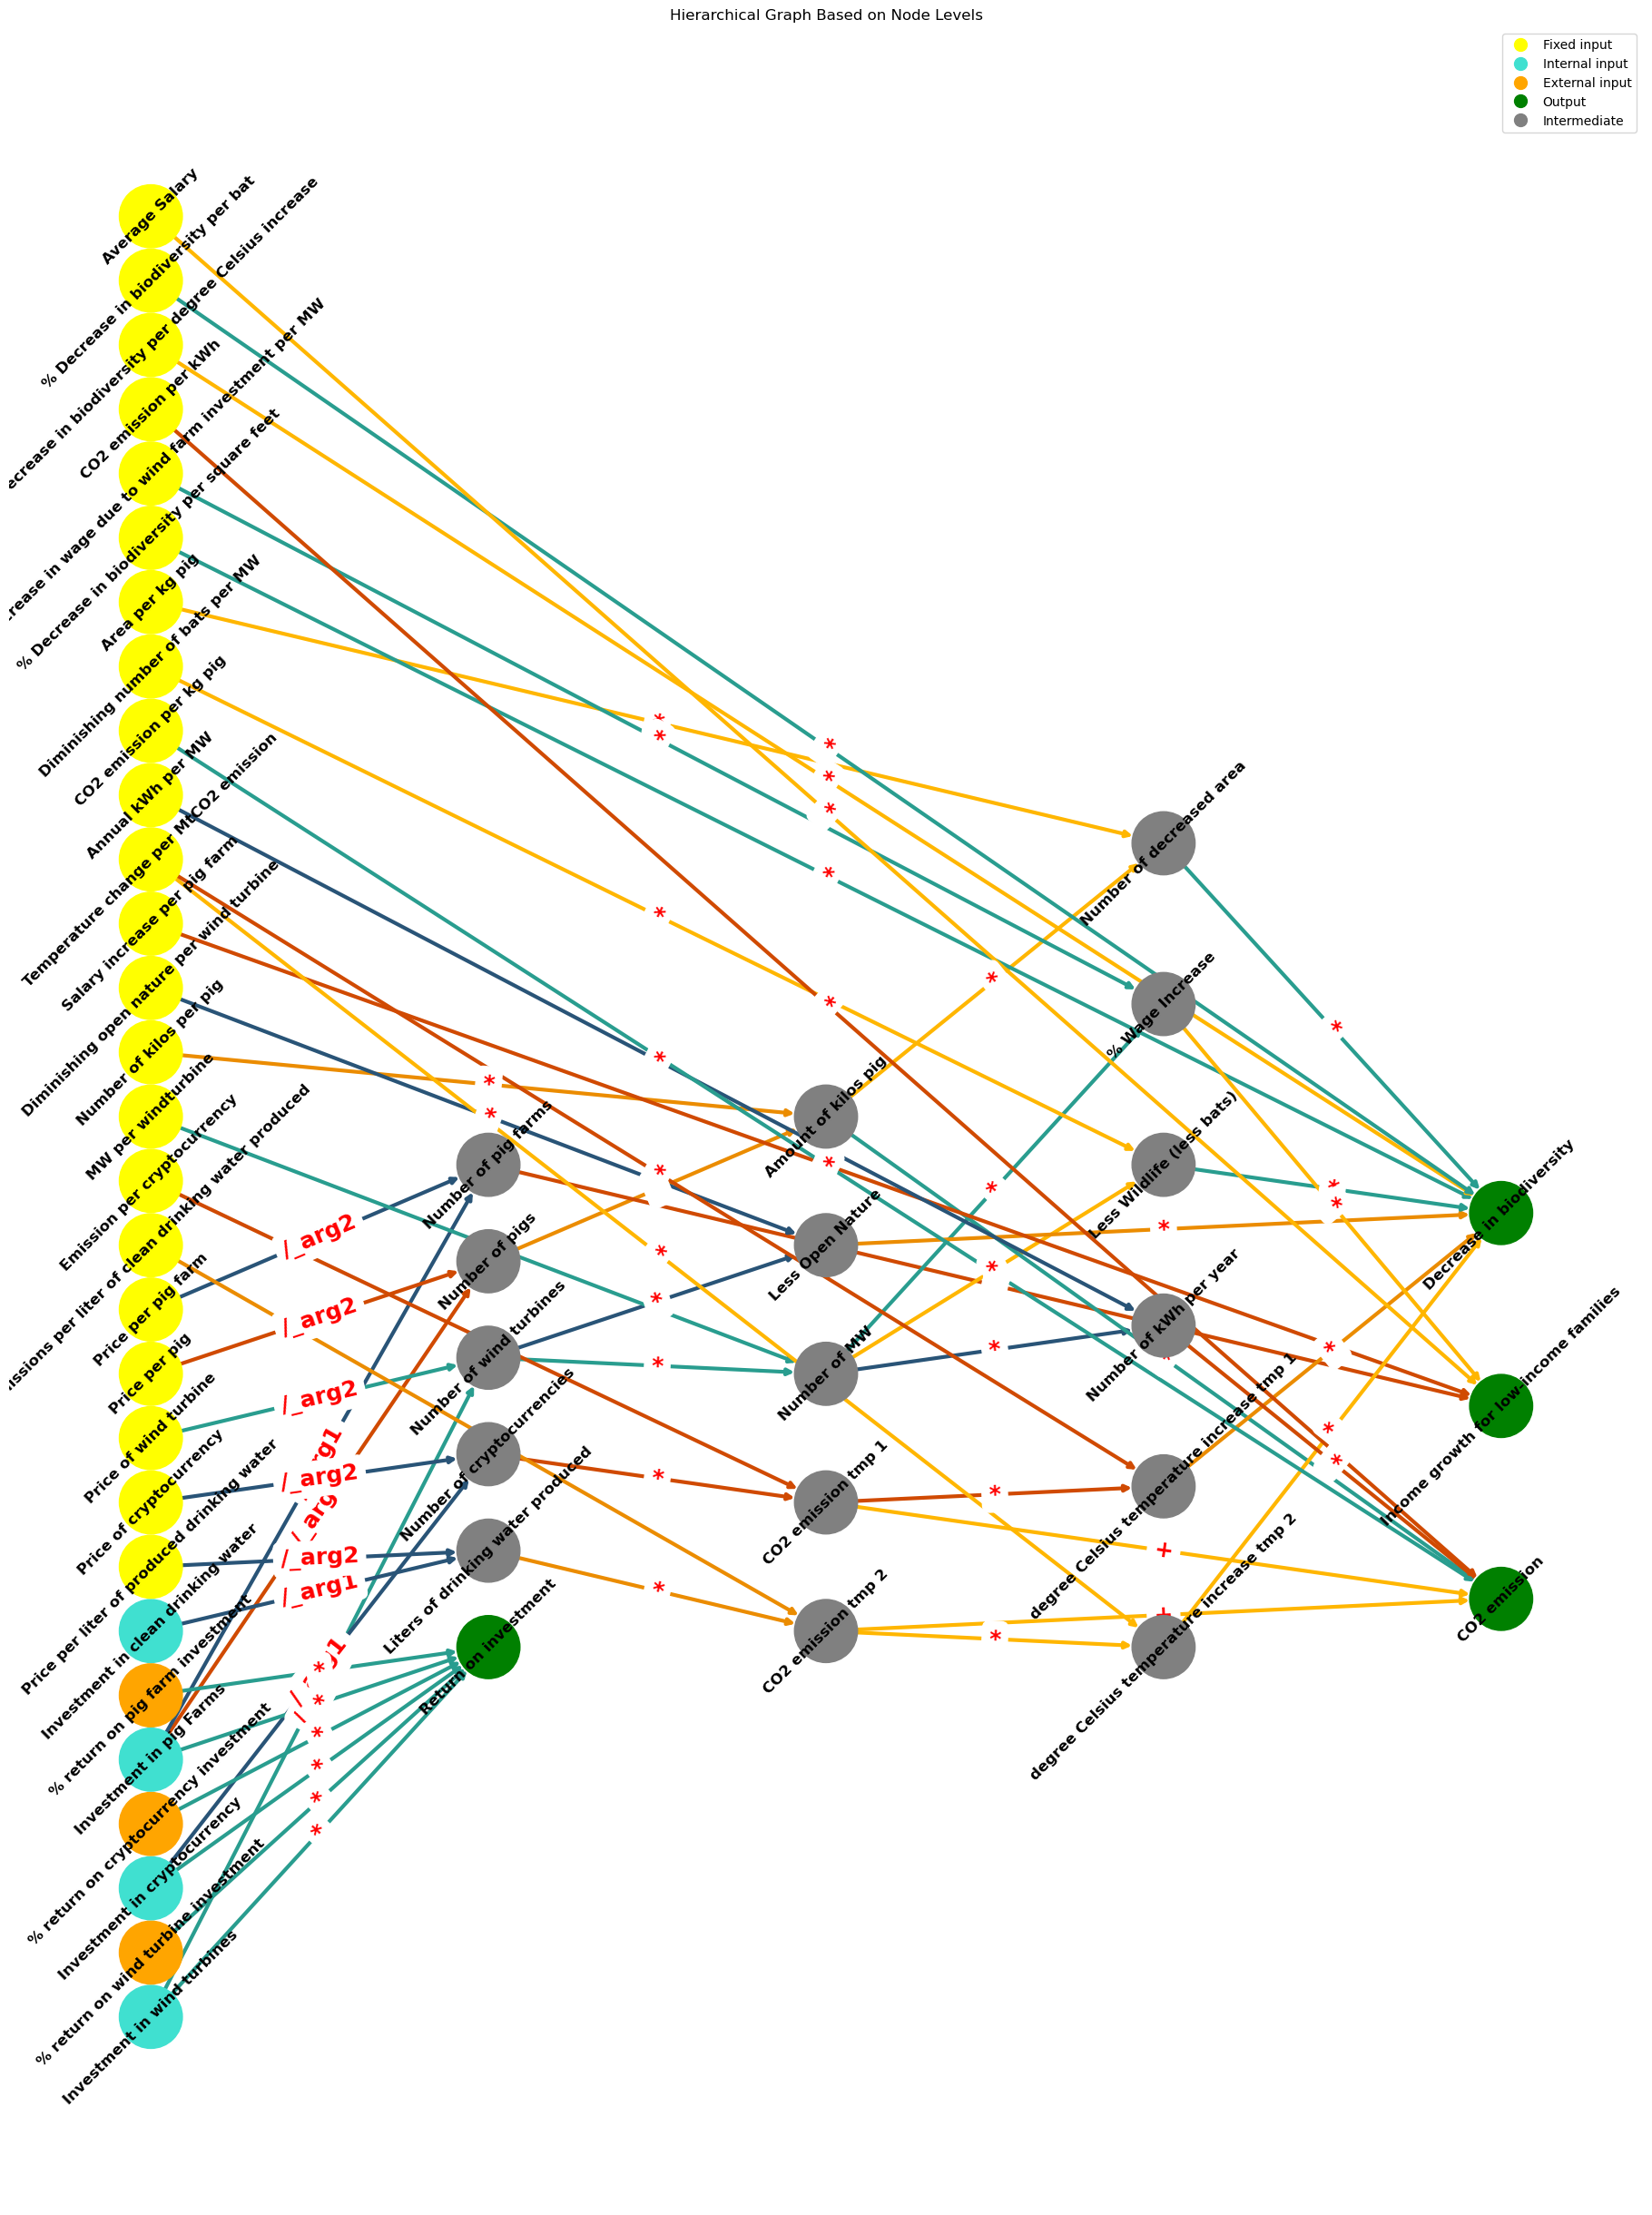

({('Investment in wind turbines', 'Return on investment'): '*',
  ('Investment in wind turbines', 'Number of wind turbines'): '/_arg1',
  ('% return on wind turbine investment', 'Return on investment'): '*',
  ('Investment in cryptocurrency', 'Return on investment'): '*',
  ('Investment in cryptocurrency', 'Number of cryptocurrencies'): '/_arg1',
  ('% return on cryptocurrency investment', 'Return on investment'): '*',
  ('Investment in pig Farms', 'Return on investment'): '*',
  ('Investment in pig Farms', 'Number of pigs'): '/_arg1',
  ('Investment in pig Farms', 'Number of pig farms'): '/_arg1',
  ('% return on pig farm investment', 'Return on investment'): '*',
  ('Liters of drinking water produced', 'CO2 emission tmp 2'): '*',
  ('Investment in clean drinking water',
   'Liters of drinking water produced'): '/_arg1',
  ('Price per liter of produced drinking water',
   'Liters of drinking water produced'): '/_arg2',
  ('Number of cryptocurrencies', 'CO2 emission tmp 1'): '*',
  ('P

In [70]:
case.visualize('network', 'key_outputs')

In [4]:
def determine_category(node):
    if node in input_dict["key_outputs"]:
        return "key_output"
    elif node in input_dict["internal_variable_inputs"]:
        return "internal_input"
    elif node in input_dict["external_variable_inputs"]:
        return "external_input"
    elif node in input_dict["fixed_inputs"]:
        return "fixed_input"
    else:
        return "intermediate"

def category_color(node):
    category_is = determine_category(node)
    if category_is == 'fixed_input':
        return 'yellow'
    elif category_is == 'external_input':
        return 'orange'
    elif category_is == 'internal_input':
        return 'turquoise'
    elif category_is == 'key_output':
        return 'green'
    else:
        # intermediaries and other unaccounted categories
        return 'grey'
    
def category_shape(node):
    category_is = determine_category(node)
    if category_is == 'fixed_input':
        return 'o'
    elif category_is == 'external_input':
        return 'o'
    elif category_is == 'internal_input':
        return 'o'
    elif category_is == 'key_output':
        return '*'
    else:
        # intermediaries and other unaccounted categories
        return 'D'

In [5]:
def create_legend(legend_dict):
    handles = []
    labels = []
    for category, color in legend_dict.items():
        handles.append(plt.Line2D([0], [0], color=color, marker='o', markersize=10, linewidth=0))
        labels.append(f'{category}')
    return handles, labels

In [6]:
def label_operators(operator, arg_type):
    label_map = {
        '/': {'arg1': '/_arg1', 'arg2': '/_arg2'},
        '-': {'arg1': '-_arg1', 'arg2': '-_arg2'},
    }
    return label_map.get(operator, {}).get(arg_type, operator)

In [151]:
def draw_graph(case, data):
    # Initialize a directed graph
    G = nx.DiGraph()

    # input_dict is used in the determine_category() 
    input_dict = case.input_dict
    
    for index, row in data.iterrows():
        destination = row['destination']
        argument_1 = row['argument_1']
        argument_2 = row['argument_2']
        operator = row['operator']
        # row_level = row['hierarchy']
        edge_color = row['dep_color']
        
        G.add_node(destination, color=category_color(destination), shape=category_shape(destination))
        
        # Add edges from argument nodes to the destination node with levels
        if pd.isnull(argument_1):
            G.add_node(argument_2, color=category_color(argument_2), shape=category_shape(argument_2))
            G.add_edge(argument_2, destination, label='squeezed', color='black', weight=1)
        elif pd.isnull(argument_2):
            G.add_node(argument_1, color=category_color(argument_1), shape=category_shape(argument_1))
            G.add_edge(argument_1, destination, label='squeezed', color='black', weight=1)
        else:
            G.add_node(argument_1, color=category_color(argument_1), shape=category_shape(argument_1))
            G.add_node(argument_2, color=category_color(argument_2), shape=category_shape(argument_2))
            G.add_edge(argument_1, destination, label=label_operators(operator, 'arg1'), color=edge_color, weight=3)
            G.add_edge(argument_2, destination, label=label_operators(operator, 'arg2'), color=edge_color, weight=3)
    
    # Create a dictionary to store nodes at each level
    nodes_by_level = defaultdict(list)
    for i, node_list in enumerate(nx.topological_generations(G)):
        for node in node_list:
            level = i
            nodes_by_level[level].append(node)

    # Create positions for nodes in the hierarchical layout
    pos = {}

    x_spacing = 10.0  # Adjust this value for spacing between levels
    y_spacing = 10.0  # Adjust this value for vertical spacing between nodes at the same level
    for level, nodes in nodes_by_level.items():
        num_nodes = len(nodes)
        x_value = level * x_spacing
        y_values = [(i*(level + 2) - (num_nodes - 1) / 2) * y_spacing for i in range(num_nodes)]
        pos.update((node, (x_value, y_value)) for node, y_value in zip(nodes, y_values))

    # Plot the graph
    edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    edge_weights = [G[u][v]['weight'] for u,v in G.edges()]
    node_colors = [G.nodes[node]["color"] for node in G.nodes()]

    legend_dict = {
        'Fixed input': 'yellow', 
        'Internal input': 'turquoise', 
        'External input': 'orange', 
        'Output': 'green', 
        'Intermediate': 'grey'
    }

    plt.figure(figsize=(45, 60))

    # with_labels=False because of rotating the node labels
    nx.draw(G, pos, node_color=node_colors, edge_color=edge_colors, width=edge_weights, with_labels=False, node_size=2500, font_size=10)

    text = nx.draw_networkx_labels(G, pos, font_weight='bold')

    # Rotate the node labels 
    for _, t in text.items():
        t.set_rotation(45) 
    nx.draw_networkx_edge_labels(G, pos, 
            edge_labels=edge_labels, 
            label_pos=0.5,
            font_color='black', 
            font_size=18, 
            font_weight='bold'
    )

    # Create and add legend
    legend_handles, legend_labels = create_legend(legend_dict)

    plt.title("Hierarchical Graph Based on Node Levels")
    plt.legend(legend_handles, legend_labels, loc='upper right')
    plt.axis('off')  # Turn off axis for cleaner display
    plt.show()

### Assigning colors and subsetting based on leaf node

In [152]:
# Function to draw the graph
def draw_subset_graph(nodes):
    ## Classifying argument1, argument2, destination
    ## Robusting TODO: Make subset graph using parent graph but without re-creating a new graph
#     print(nodes)
    tuples = []
    for index, row in data.iterrows():
        destination = row['destination']
        argument_1 = row['argument_1']
        argument_2 = row['argument_2']
        operator = row['operator']
        # row_level = row['hierarchy']
        edge_color = row['dep_color']
        
#         nodes_clone = nodes.copy()
        if ((argument_1 in nodes) or (argument_2 in nodes)) and (destination in nodes):
            t = (argument_1, argument_2, destination, operator, edge_color)
            tuples.append(t)
            # POTENTIAL BUG: What if a node is used in multiple rows?
    
    # Make the graph and add the nodes
    G = nx.DiGraph()
    for t in tuples:
        G.add_node(t[2], color=category_color(t[2]))
        
        # Add edges from argument nodes to the destination node with levels
        if pd.isna(t[0]):
            G.add_node(t[1], color=category_color(t[1]))
            G.add_edge(t[1], t[2], label='squeezed', color='black', weight=1)
        elif pd.isna(t[1]):
            G.add_node(t[0], color=category_color(t[0]))
            G.add_edge(t[0], t[2], label='squeezed', color='black', weight=1)
        else:
            G.add_node(t[0], color=category_color(t[0]))
            G.add_node(t[1], color=category_color(t[1]))
            G.add_edge(t[0], t[2], label=label_operators(t[3], "arg1"), color=t[4], weight=3)
            G.add_edge(t[1], t[2], label=label_operators(t[3], "arg2"), color=t[4], weight=3)
    
    # Create a dictionary to store nodes at each level
    nodes_by_level = defaultdict(list)
    for i, node_list in enumerate(nx.topological_generations(G)):
        for node in node_list:
            level = i
            nodes_by_level[level].append(node)
    
    # Create positions for nodes in the hierarchical layout
    pos = {}

    # LEFT TO RIGHT
    x_spacing = 1.0  # Adjust this value for spacing between levels
    y_spacing = 1.0  # Adjust this value for vertical spacing between nodes at the same level
    for level, nodes in nodes_by_level.items():
        num_nodes = len(nodes)
        x_value = level * x_spacing
        y_values = [(i*(level + 2) - (num_nodes - 1) / 2) * y_spacing for i in range(num_nodes)]
        pos.update((node, (x_value, y_value)) for node, y_value in zip(nodes, y_values))

    # Plot the graph
    edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    edge_weights = [G[u][v]['weight'] for u,v in G.edges()]
    node_colors = [G.nodes[node]["color"] for node in G.nodes()]
    
    plt.figure(figsize=(18, 24))

    # with_labels=False because of rotating the node labels
    nx.draw(G, pos, node_color=node_colors, edge_color=edge_colors, width=edge_weights, with_labels=False, node_size=2500)

    text = nx.draw_networkx_labels(G, pos, font_weight='bold')

    # Rotate the node labels 
    for _, t in text.items():
        t.set_rotation(45) 
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw_networkx_edge_labels(G, pos, 
        edge_labels=edge_labels, 
        label_pos=0.5,
        font_color='black', 
        font_size=18, 
        font_weight='bold'
    )

    # Create and add legend
    legend_handles, legend_labels = create_legend(legend_dict)

    plt.title("Hierarchical Graph Based on Node Levels")
    plt.legend(legend_handles, legend_labels, loc='upper right')
    plt.axis('off')  # Turn off axis for cleaner display
    plt.show()

In [153]:
def select_subset(G, name_of_node):
    # Match to closest node
    name_of_node = "".join(get_close_matches(word=name_of_node, possibilities=list(G), n=1))
    ## TODO: Assert name_of_node is not empty
    nodes_subset = list(nx.ancestors(G, name_of_node))
    nodes_subset.append(name_of_node)
    nodes_subset += nx.descendants(G, name_of_node)
#     print(nodes_subset)
#     print(nx.ancestors(G, name_of_node))
#     print(nx.descendants(G, name_of_node))
    # nx.draw(ancestors, pos, node_color=node_colors, with_labels=False, node_size=1200, font_size=10)
    draw_subset_graph(nodes_subset)

## Toy Example:
### Farmer has TWO choices:

1. Invest in Apples
2. Invest in Machinery

In [154]:
# Read the CSV file
data = pd.read_csv('data/toy/csv/dependencies.csv')

path = Path.cwd() / 'data'
file_format = 'xlsx'
name = 'toy'

case = TheResponsibleBusinessSimulator(path, file_format, name)
case.build()

data = pd.DataFrame({
    'argument_1': case.input_dict['argument_1'], 
    'operator': case.input_dict['operator'], 
    'argument_2': case.input_dict['argument_2'], 
    'destination': case.input_dict['destination']
})

data

Creating 'toy'
Hierarchy calculated in 2 iterations


argument_1 operator              argument_2  \
0     investment in apples        *            % ROI apples   
1  investment in machinery        *         % ROI machinery   
2  investment in machinery        /        cost of machines   
3       number of machines        *  efficiency per machine   

          destination  
0              profit  
1              profit  
2  number of machines  
3          efficiency

In [155]:
# Initialize a directed graph
G = nx.DiGraph()

input_dict = case.input_dict

# Iterate through the rows of the DataFrame to add nodes and edges
for index, row in data.iterrows():
    destination = row['destination']
    argument_1 = row['argument_1']
    argument_2 = row['argument_2']
    operator = row['operator']
    
    # Add nodes for destination, argument_1, and argument_2
    G.add_node(destination, color = category_color(destination))
    G.add_node(argument_1, color = category_color(argument_1))
    G.add_node(argument_2, color = category_color(argument_2))
    
    # Add an edge from argument_1 to destination with the operator as the label
    if pd.isna(argument_1):
        G.add_edge(argument_2, destination, label='squeezed', color='black')
    elif pd.isna(argument_2):
        G.add_edge(argument_1, destination, label='squeezed', color='black')
    else:
        G.add_edge(argument_1, argument_2, label=operator, color='black')
        # Later make function so that based on category, we make the edge to destination
        G.add_edge(argument_2, destination, label='=', color='black')

In [156]:
number_of_colors = len(data)

COLOR_LIST = ['#000000', '#AD1B02', '#D85604', '#E88D14', '#F3BE26', '#E669A2']
# color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#              for i in range(number_of_colors)]

color = random.choices(COLOR_LIST, k=number_of_colors)
data['dep_color'] = color

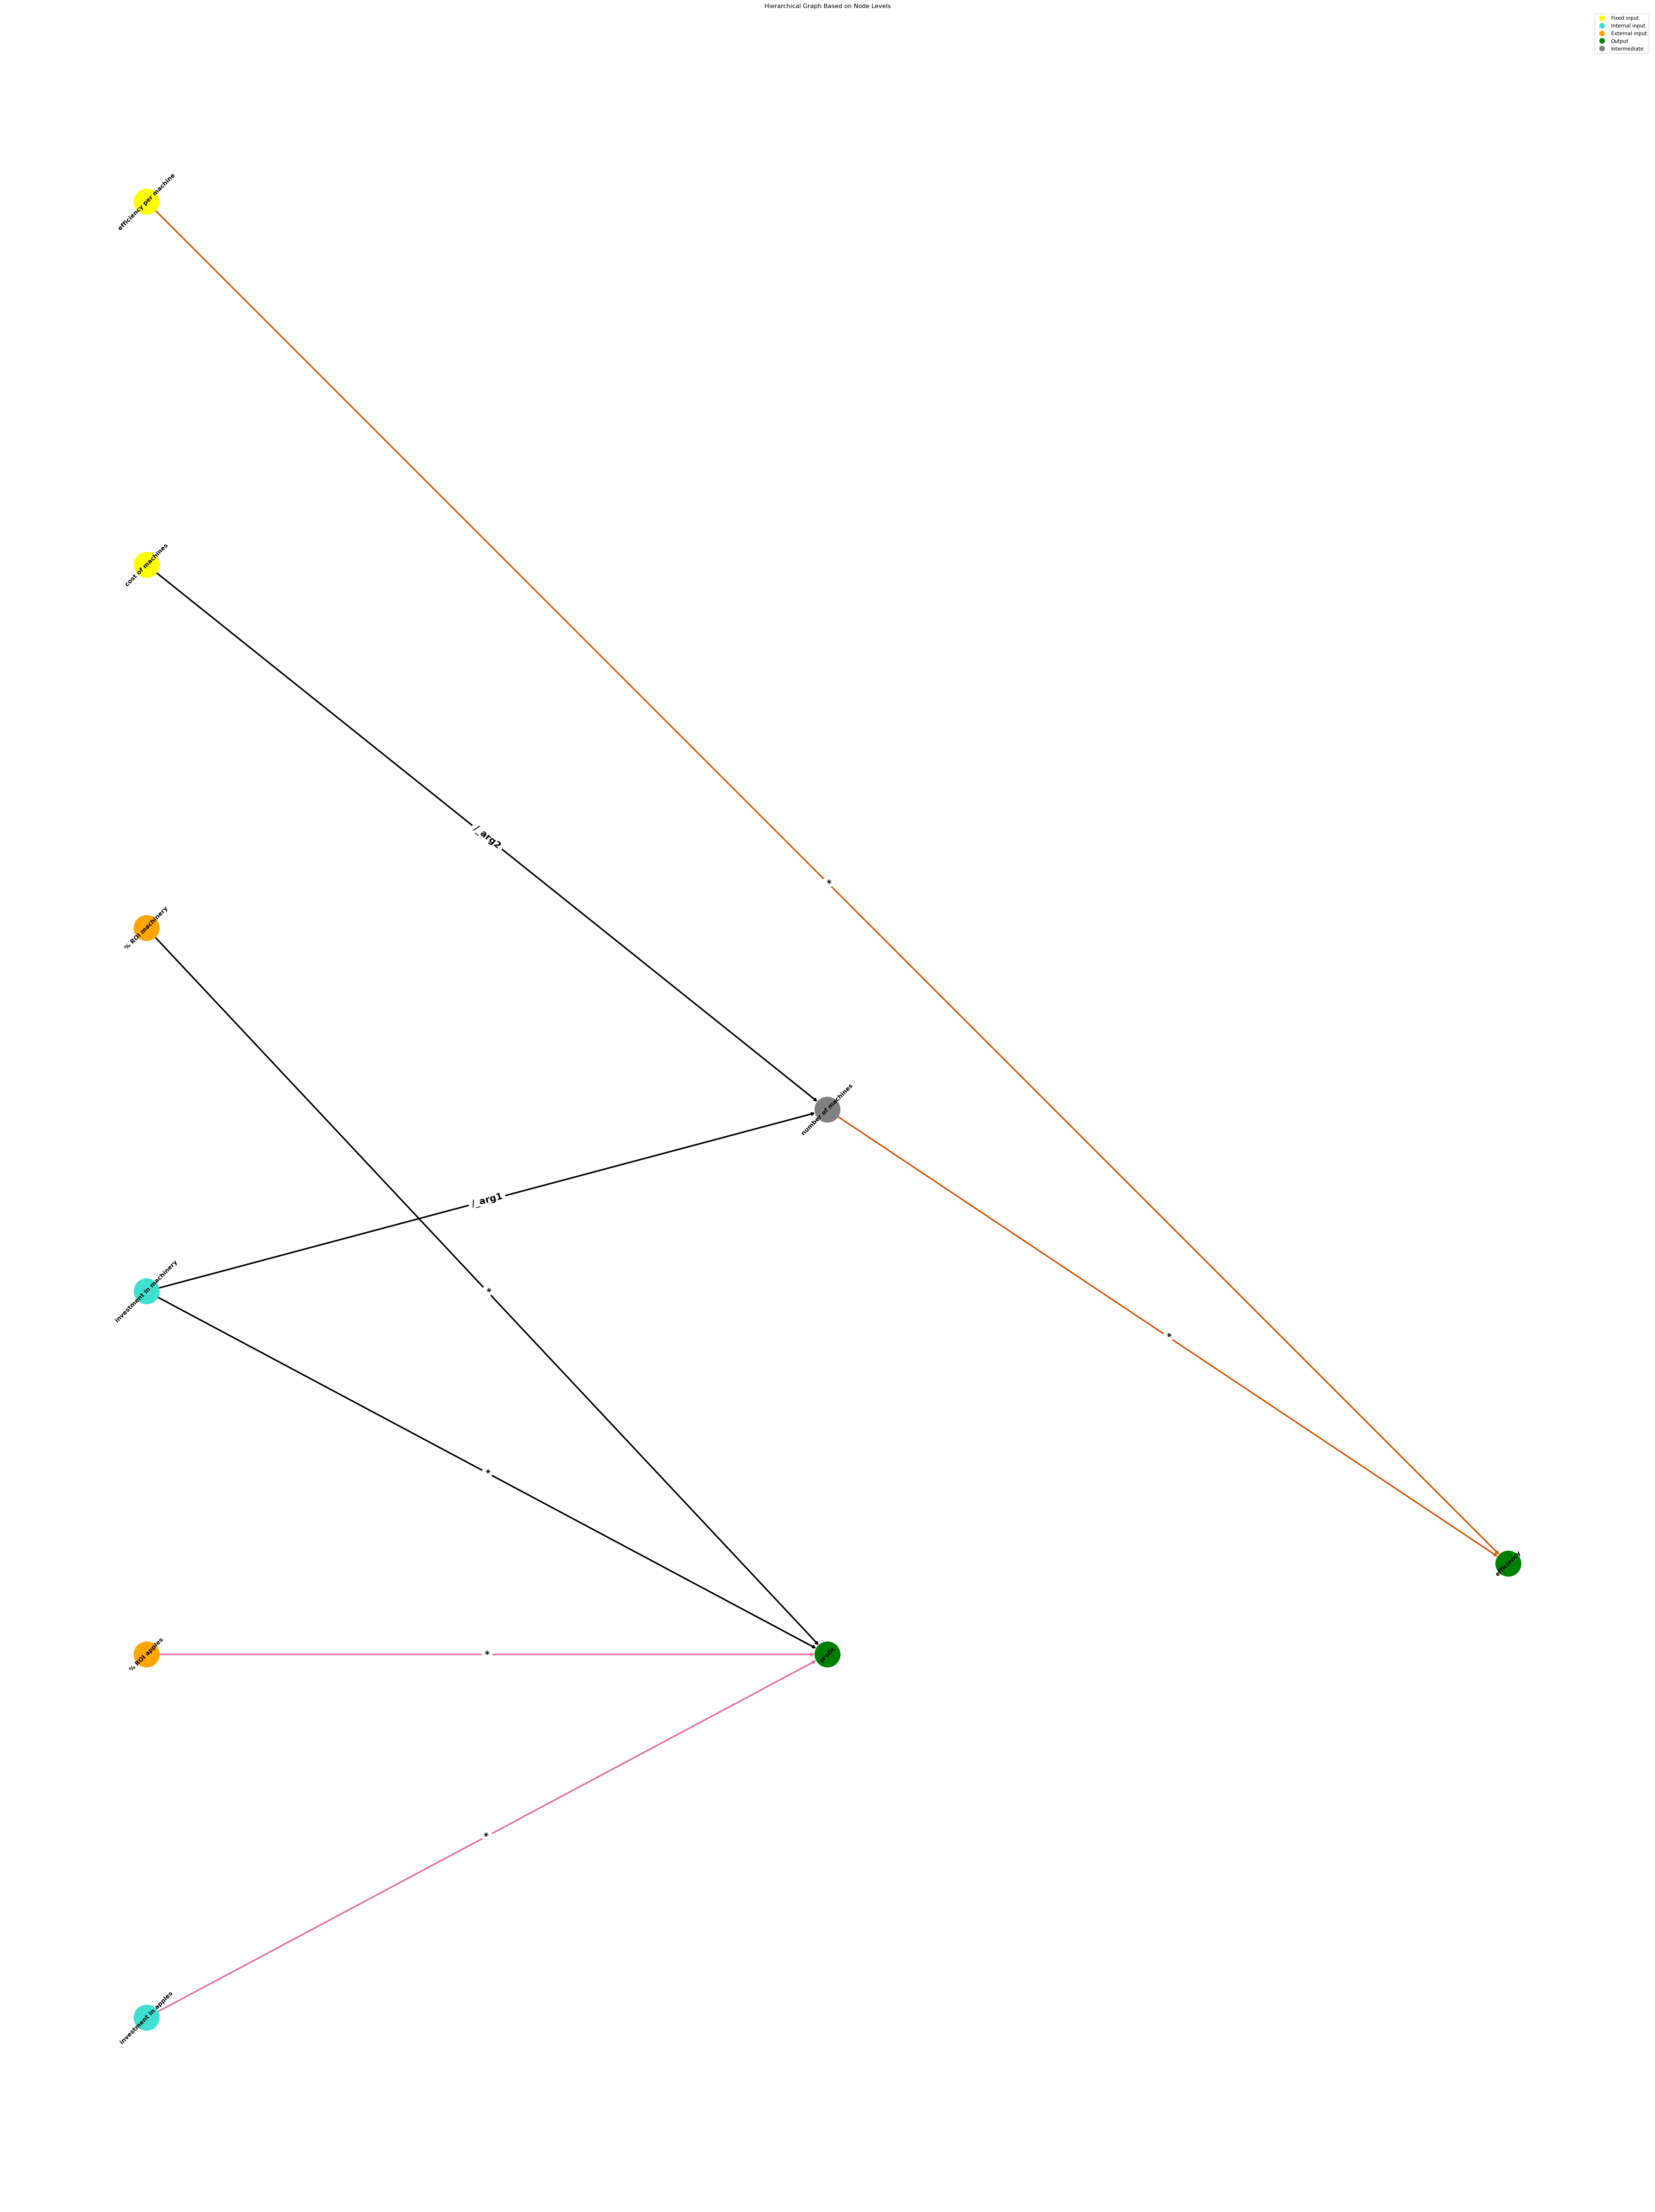

In [157]:
draw_graph(case, data)

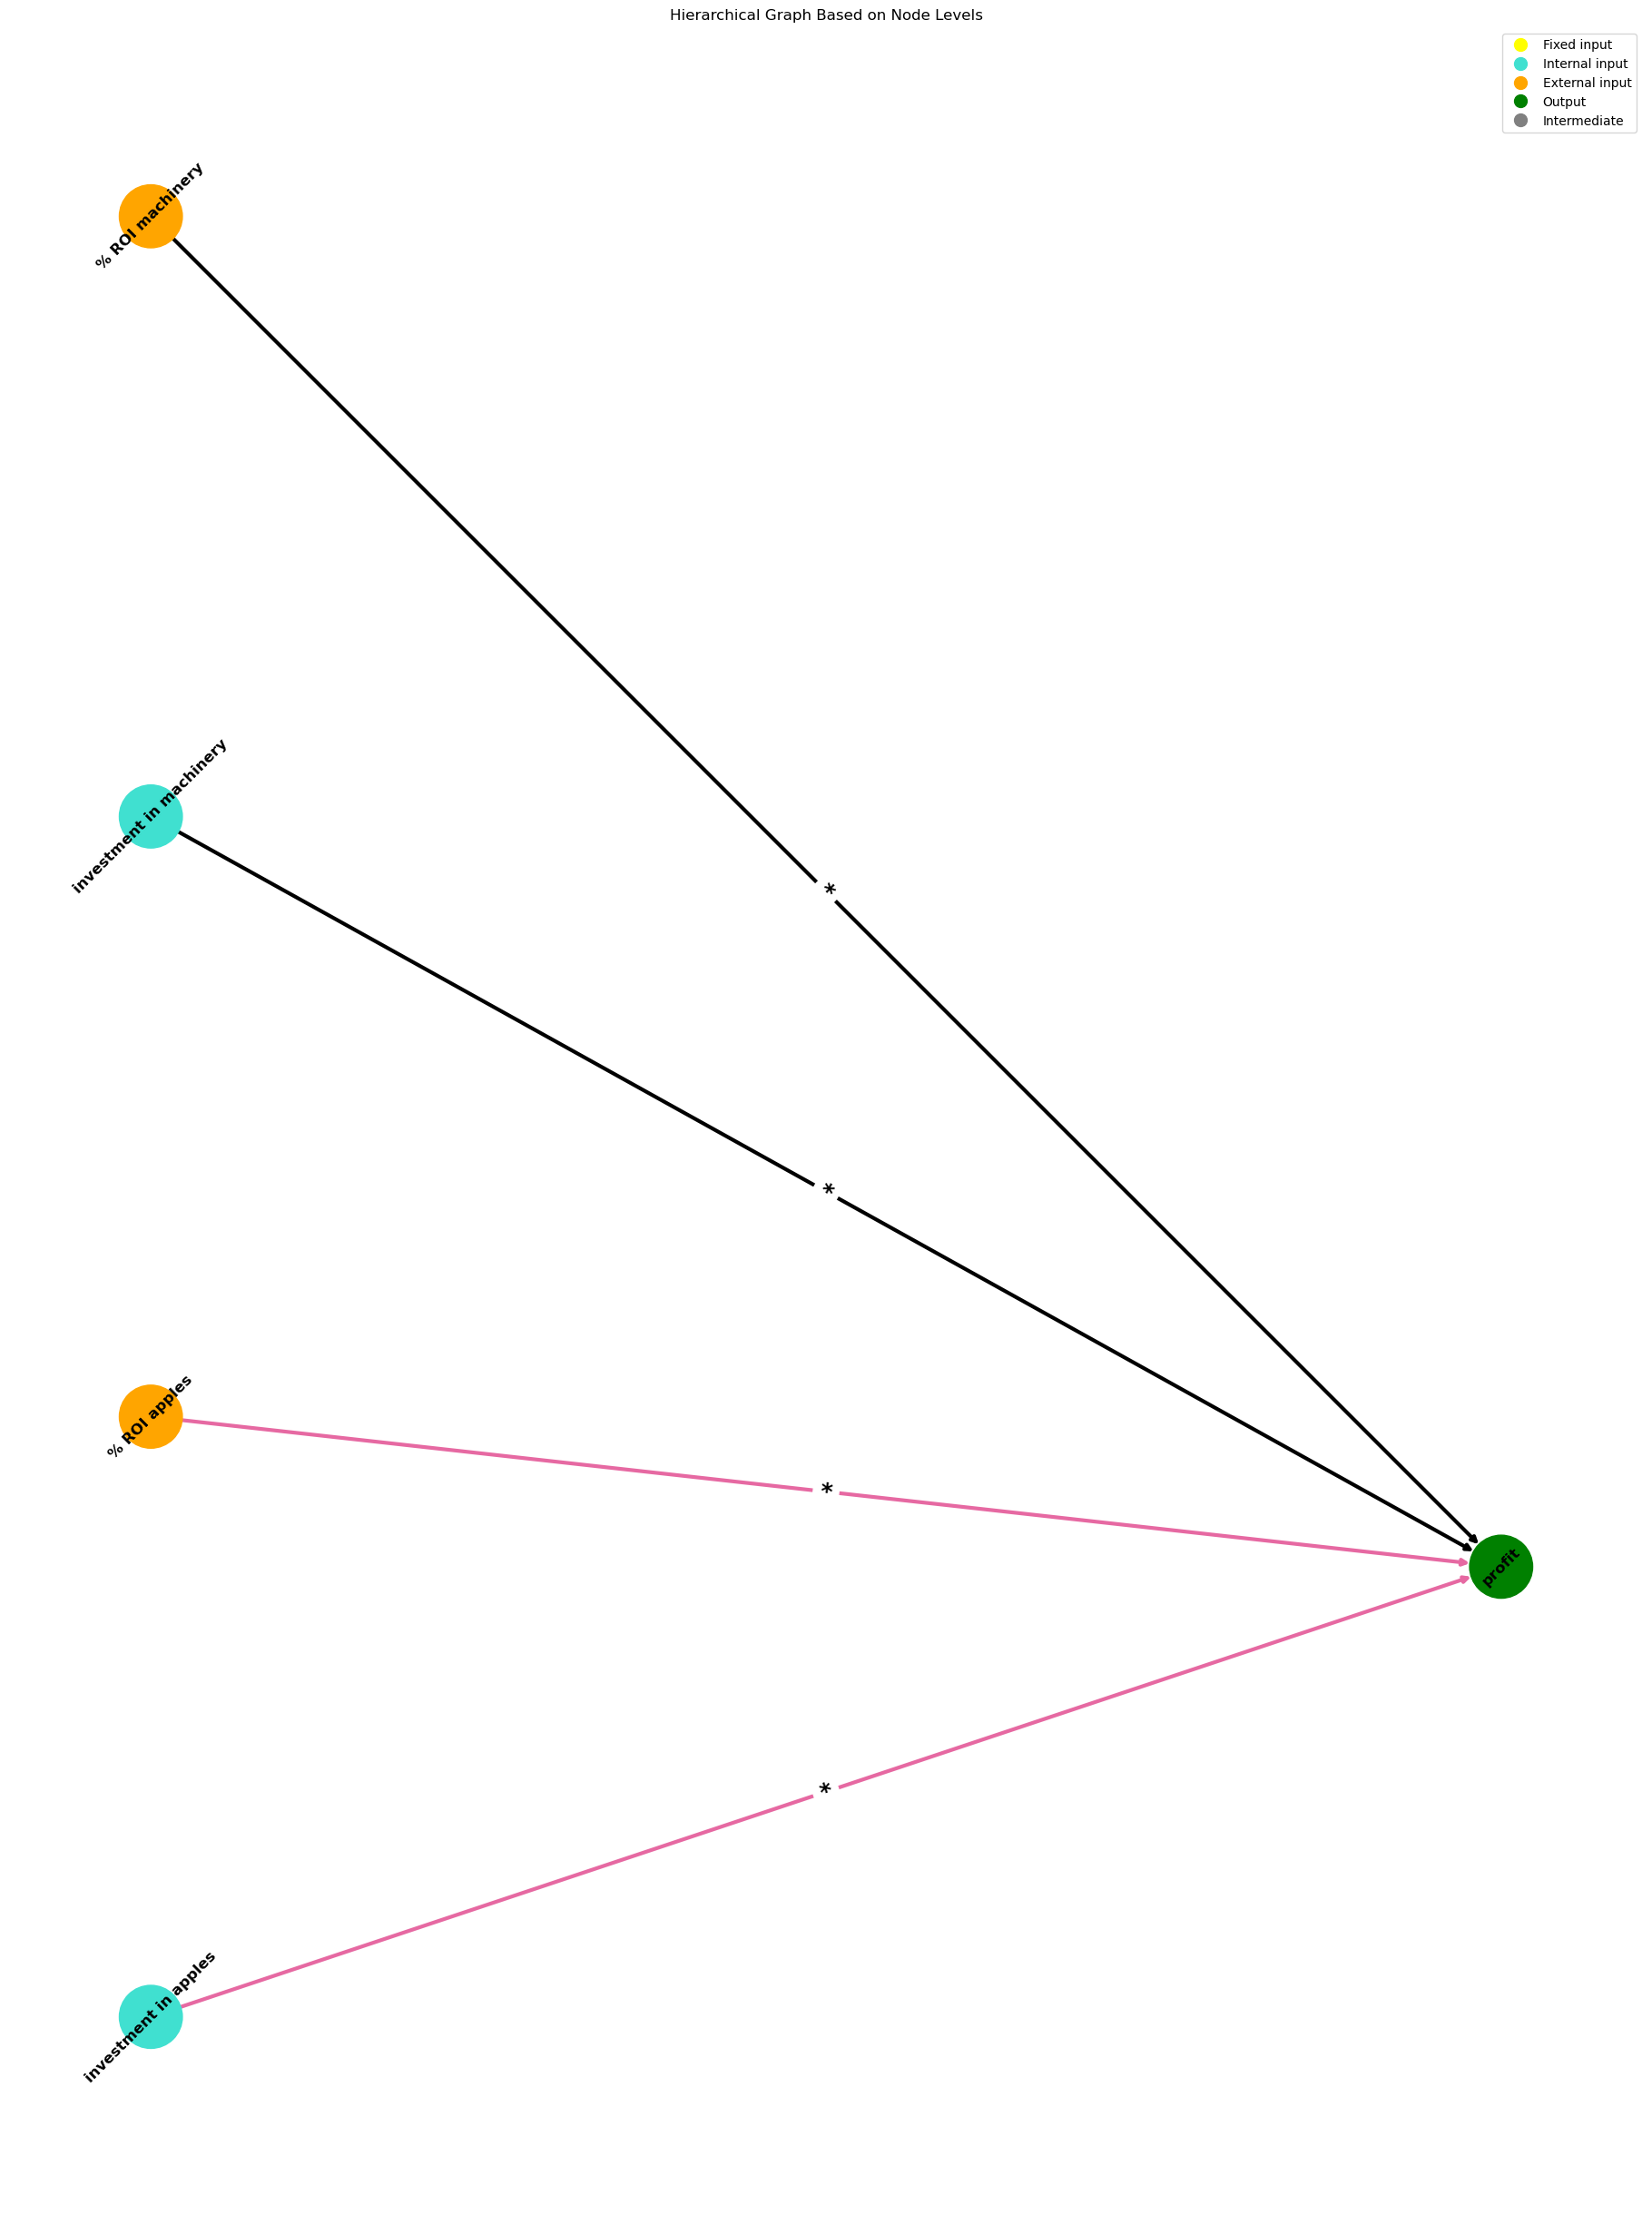

In [158]:
select_subset(G, 'profit')

## Refugee case

In [180]:
# Read the CSV file
data = pd.read_csv('data/refugee/csv/dependencies.csv')

path = Path.cwd() / 'data'
file_format = 'xlsx'
name = 'refugee'

case = TheResponsibleBusinessSimulator(path, file_format, name)
case.build()

data = pd.DataFrame({
    'argument_1': case.input_dict['argument_1'], 
    'operator': case.input_dict['operator'], 
    'argument_2': case.input_dict['argument_2'], 
    'destination': case.input_dict['destination']
})

data

Creating 'refugee'
Hierarchy calculated in 26 iterations


argument_1    operator  \
0                               Education after 18  squeezed *   
1                           Sports and association           >   
2                  Language and integration course           >   
3                                       Employment           >   
4                               Education after 18           >   
..                                             ...         ...   
92  Quality of life other refugees Personal safety           +   
93                 Economic impact Social benefits           +   
94                      Personal safety Ukrainians           *   
95      Quality of life Ukrainians Personal safety           +   
96  Quality of life inhabitants Financial security           +   

                                           argument_2  \
0                                                 NaN   
1                                                   0   
2                                                   0   
3                                                   0   
4                                                   0   
..                                                ...   
92                                                  0   
93                                                  0   
94  Effect of personal safety Ukrainians on qualit...   
95         Quality of life Ukrainians Social cohesion   
96        Quality of life inhabitants Personal safety   

                                   destination  
0      Tertiary education completed Ukrainians  
1                Sports and association exists  
2       Language and integration course exists  
3                            Employment exists  
4                             Education exists  
..                                         ...  
92              Quality of life other refugees  
93                             Economic impact  
94  Quality of life Ukrainians Personal safety  
95                  Quality of life Ukrainians  
96                 Quality of life inhabitants  

[97 rows x 4 columns]

In [181]:
# Initialize a directed graph
G = nx.DiGraph()

input_dict = case.input_dict

# Iterate through the rows of the DataFrame to add nodes and edges
for index, row in data.iterrows():
    destination = row['destination']
    argument_1 = row['argument_1']
    argument_2 = row['argument_2']
    operator = row['operator']
    
    # Add nodes for destination, argument_1, and argument_2
    G.add_node(destination, color = category_color(destination))
    
    # Add an edge from argument_1 to destination with the operator as the label
    if pd.isnull(argument_1):
        print(argument_2, category_color(argument_2))
        G.add_node(argument_2, color = category_color(argument_2))
        G.add_edge(argument_2, destination, label=operator, color='black')
    elif pd.isnull(argument_2):
        print(argument_1, category_color(argument_1))
        G.add_node(argument_1, color = category_color(argument_1))
        G.add_edge(argument_1, destination, label=operator, color='black')
    else:
        G.add_node(argument_1, color = category_color(argument_1))
        G.add_node(argument_2, color = category_color(argument_2))
        G.add_edge(argument_1, argument_2, label=operator, color='black')
        # Later make function so that based on category, we make the edge to destination
        G.add_edge(argument_2, destination, label='=', color='black')

Education after 18 turquoise
Sports and association turquoise
Language and integration course turquoise
Employment turquoise
Sports and association turquoise
Access to transport turquoise
Sports and association turquoise
Access to transport turquoise


In [182]:
number_of_colors = len(data)

COLOR_LIST = ['#000000', '#AD1B02', '#D85604', '#E88D14', '#F3BE26', '#E669A2']
# color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#              for i in range(number_of_colors)]

color = random.choices(COLOR_LIST, k=number_of_colors)
data['dep_color'] = color

In [183]:
draw_graph(case, data)

NetworkXUnfeasible: Graph contains a cycle or graph changed during iteration

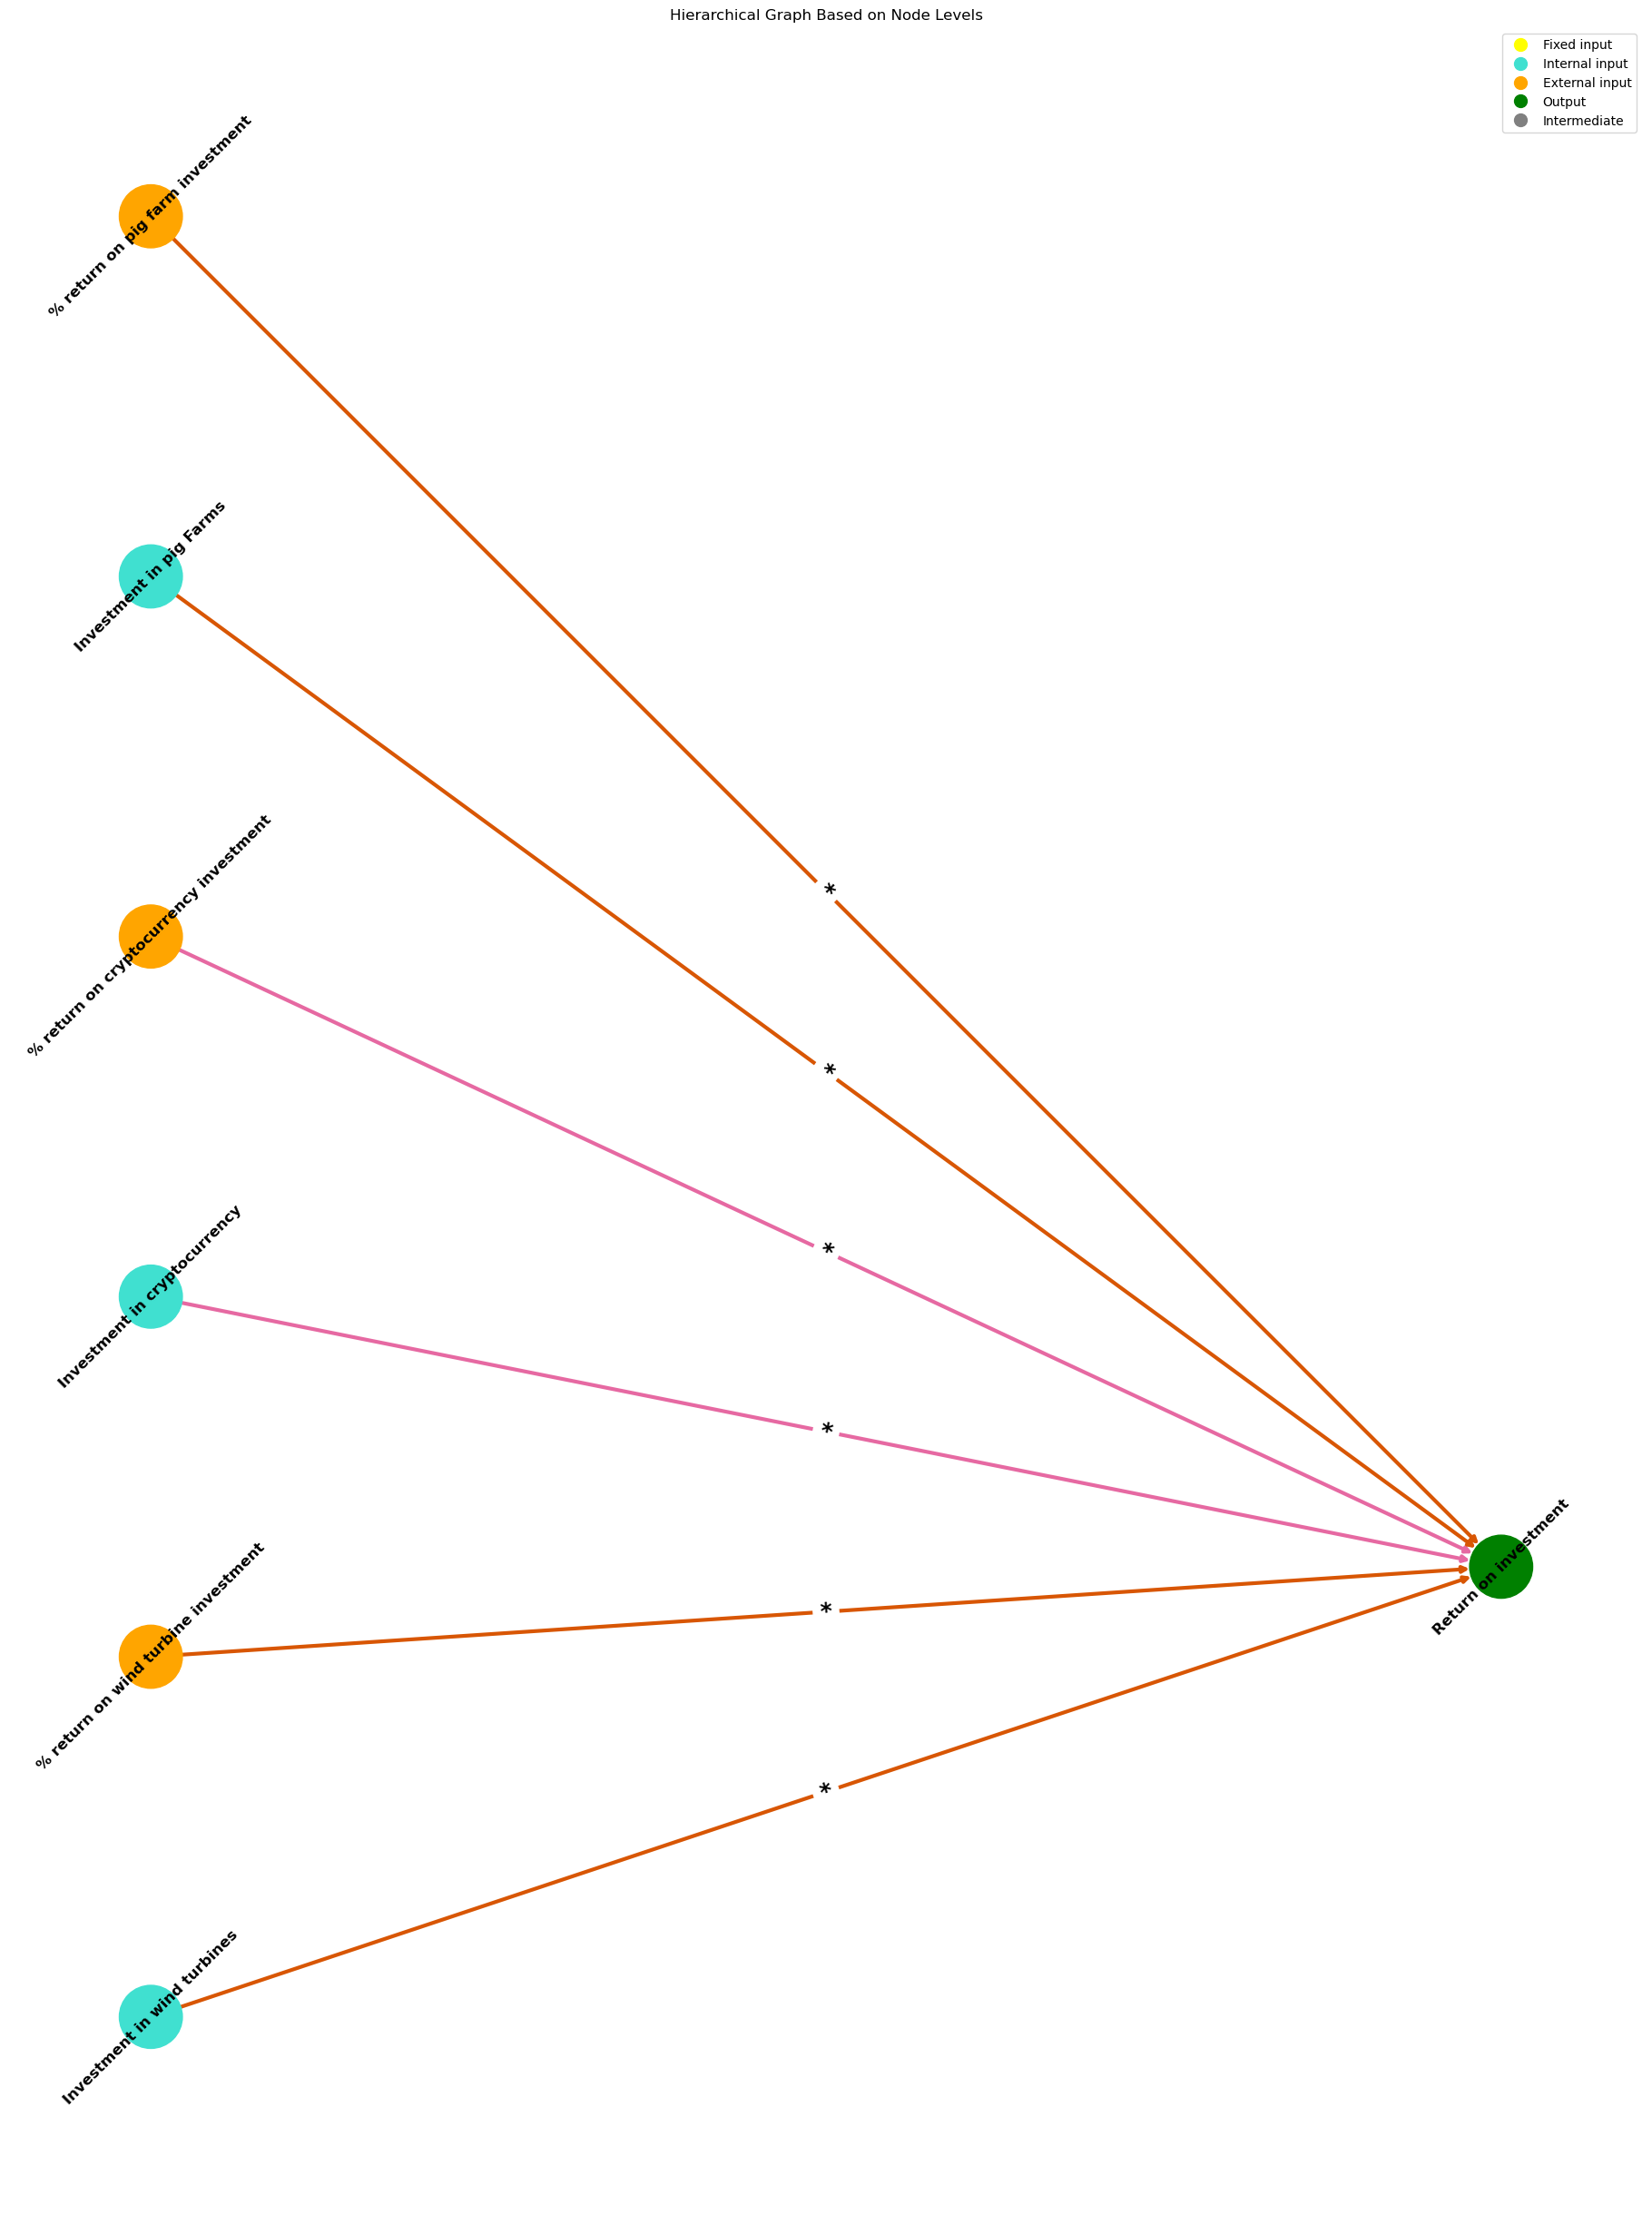

In [163]:
select_subset(G, 'Return on investment')

## For the beerwiser case

In [164]:
path = Path.cwd() / 'data'
file_format = 'xlsx'
name = 'beerwiser'

case = TheResponsibleBusinessSimulator(path, file_format, name)
case.build()

data = pd.DataFrame({
    'argument_1': case.input_dict['argument_1'], 
    'operator': case.input_dict['operator'], 
    'argument_2': case.input_dict['argument_2'], 
    'destination': case.input_dict['destination']
})

data

Creating 'beerwiser'
Hierarchy calculated in 5 iterations


argument_1    operator  \
0        Invest in training of employees  squeezed *   
1              Invest in water recycling  squeezed *   
2        Invest in training of employees           /   
3   Water use reduction % when effective           *   
4                    Current # accidents           *   
5                  Water use reduction %           *   
6                    Accidents reduction           *   
7                    Current # accidents           -   
8                    Water use reduction           *   
9                      Current water use           -   
10           Production cost reduction $           /   

                       argument_2                           destination  
0                             NaN                 Accidents reduction %  
1                             NaN  Water use reduction % when effective  
2                     # employees         Cost of training per employee  
3   Effectiveness water recycling                 Water use reduction %  
4           Accidents reduction %                   Accidents reduction  
5               Current water use                   Water use reduction  
6                Cost of accident           Production cost reduction $  
7             Accidents reduction                       New # accidents  
8                 Water unit cost           Production cost reduction $  
9             Water use reduction                         New water use  
10        Current production cost             Production cost reduction

In [165]:
# Initialize a directed graph
G = nx.DiGraph()

input_dict = case.input_dict

# Iterate through the rows of the DataFrame to add nodes and edges
for index, row in data.iterrows():
    destination = row['destination']
    argument_1 = row['argument_1']
    argument_2 = row['argument_2']
    operator = row['operator']
    
    # Add nodes for destination, argument_1, and argument_2
    G.add_node(destination, color = category_color(destination))
    
    # Add an edge from argument_1 to destination with the operator as the label
    if pd.isnull(argument_1):
        print(argument_2, category_color(argument_2))
        G.add_node(argument_2, color = category_color(argument_2))
        G.add_edge(argument_2, destination, label=operator, color='black')
    elif pd.isnull(argument_2):
        print(argument_1, category_color(argument_1))
        G.add_node(argument_1, color = category_color(argument_1))
        G.add_edge(argument_1, destination, label=operator, color='black')
    else:
        G.add_node(argument_1, color = category_color(argument_1))
        G.add_node(argument_2, color = category_color(argument_2))
        G.add_edge(argument_1, argument_2, label=operator, color='black')
        # Later make function so that based on category, we make the edge to destination
        G.add_edge(argument_2, destination, label='=', color='black')

Invest in training of employees turquoise
Invest in water recycling turquoise


In [166]:
number_of_colors = len(data)

COLOR_LIST = ['#000000', '#AD1B02', '#D85604', '#E88D14', '#F3BE26', '#E669A2']
# color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#              for i in range(number_of_colors)]

color = random.choices(COLOR_LIST, k=number_of_colors)
data['dep_color'] = color

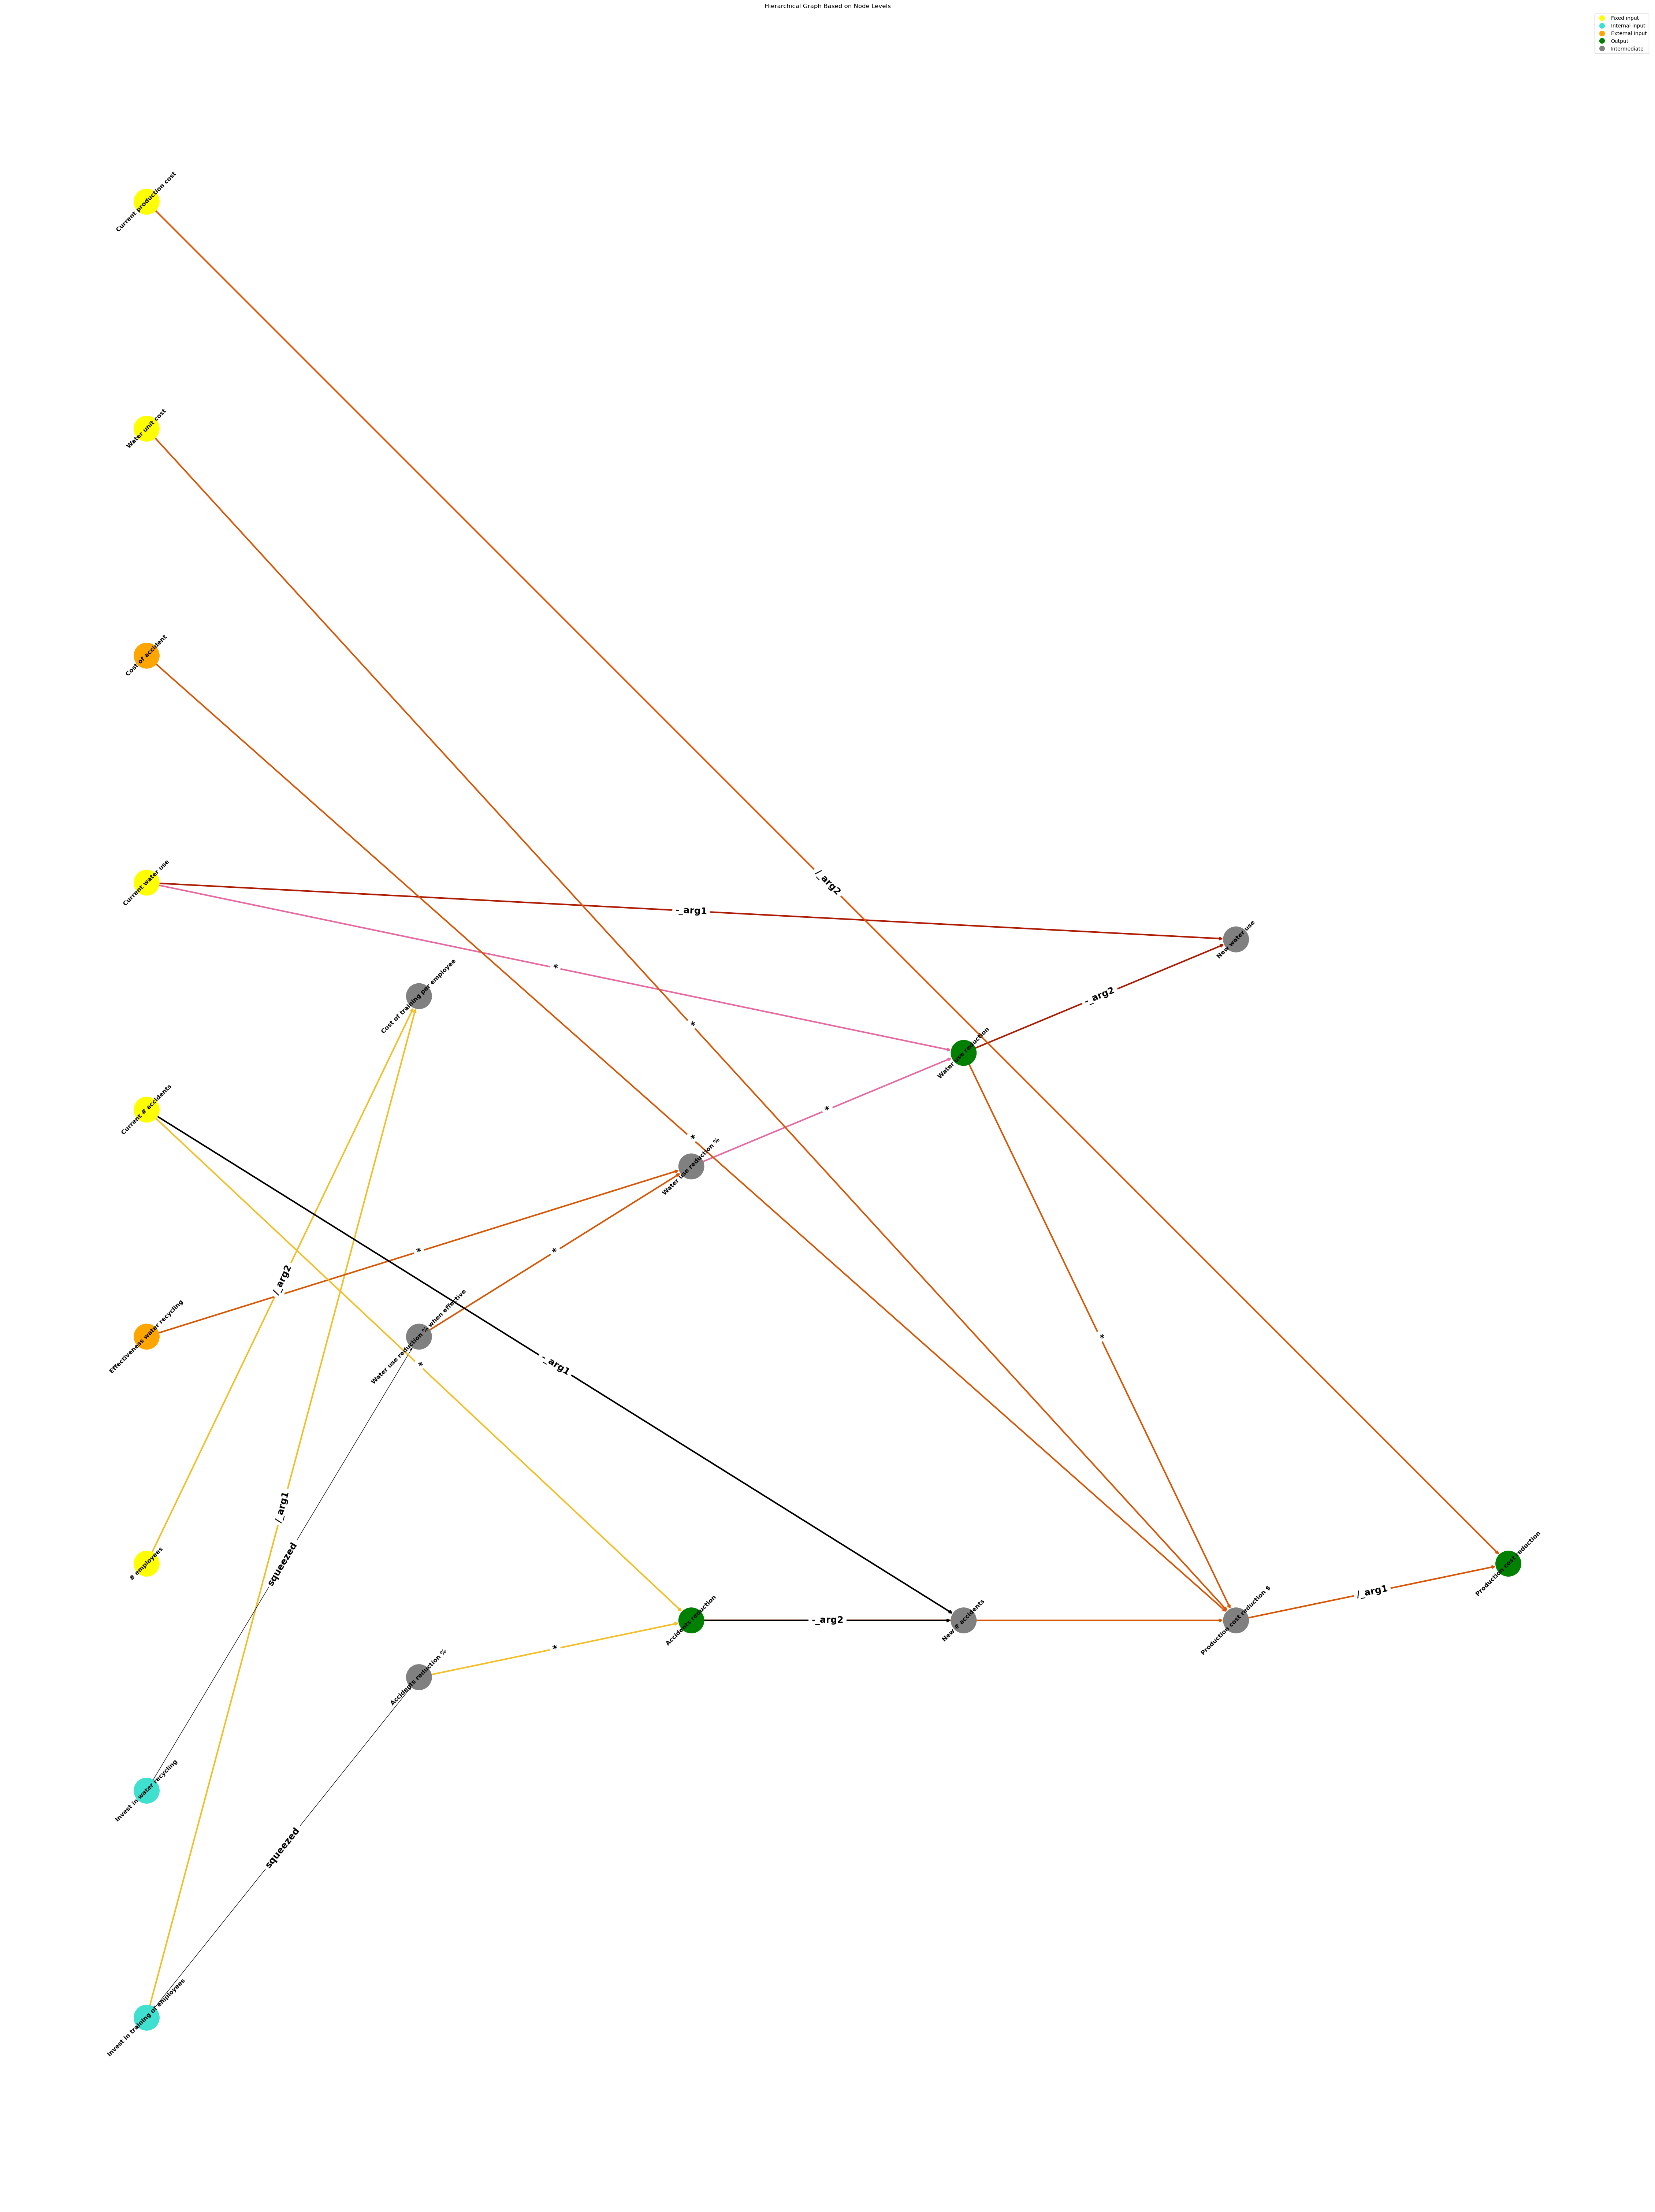

In [167]:
draw_graph(case, data)

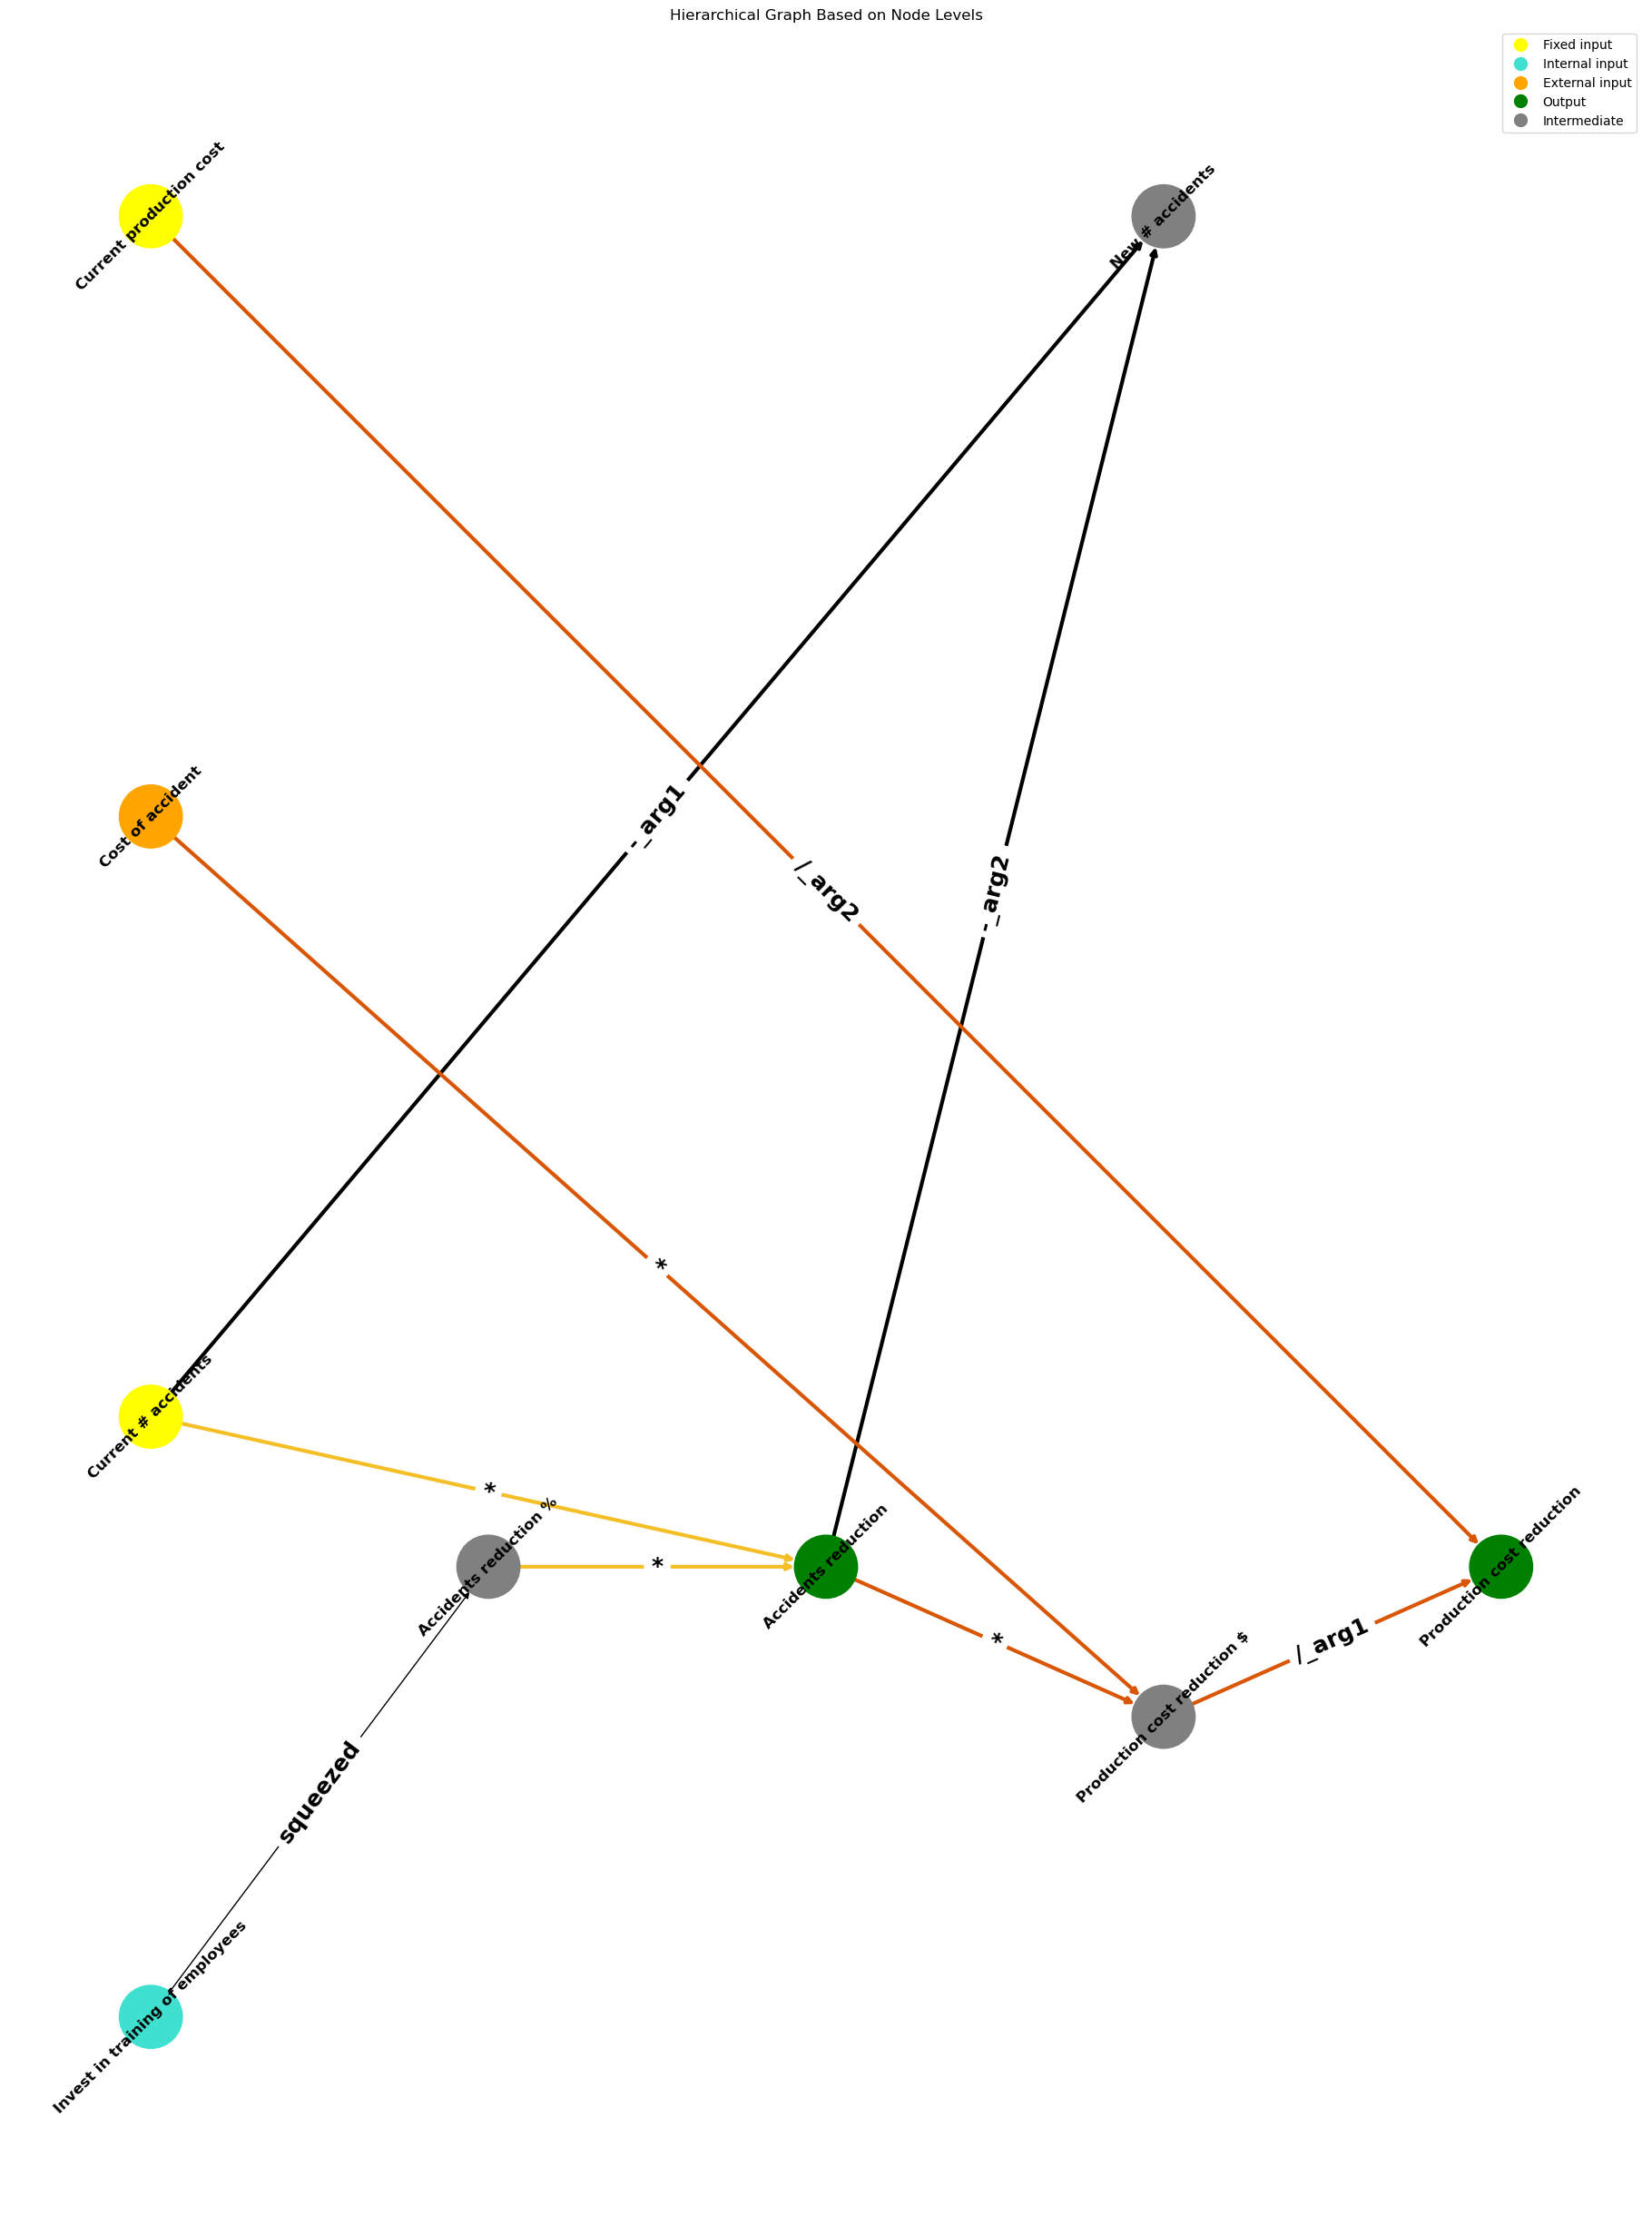

In [168]:
select_subset(G, 'Accidents reduction')

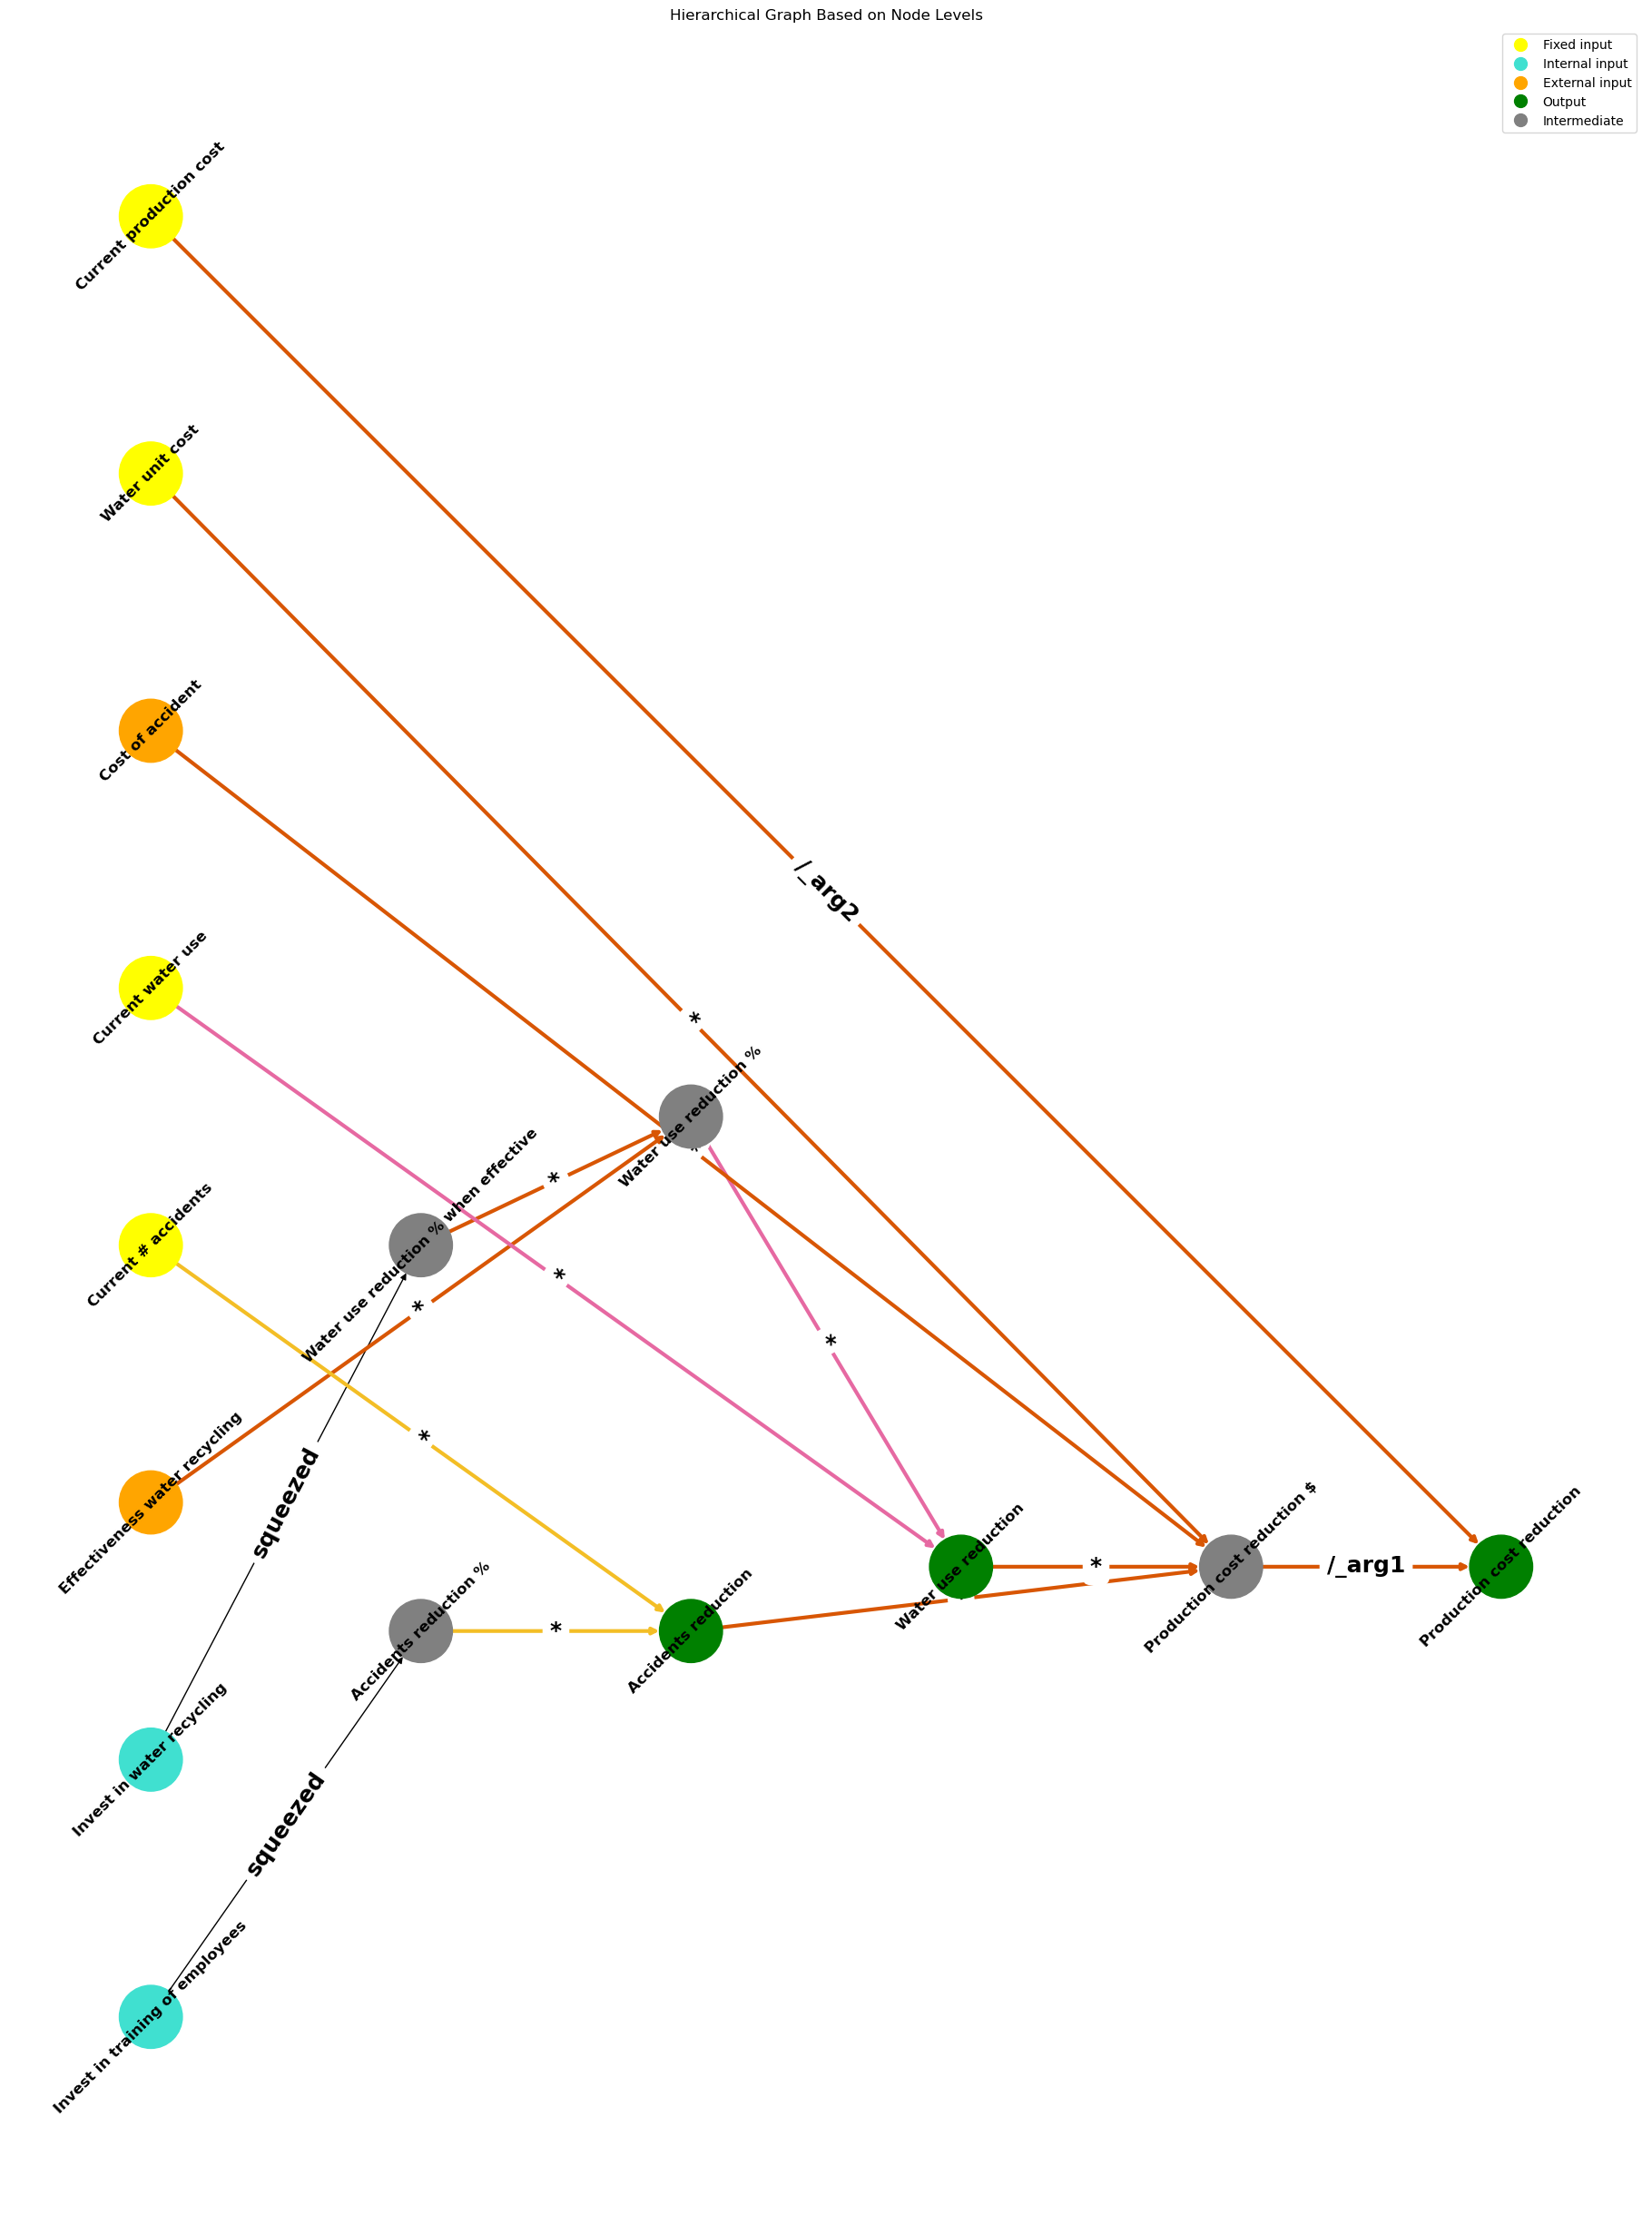

In [169]:
select_subset(G, 'Production cost reduction')

## Hierarchy

In [170]:
# Read the data and build the case
path = Path.cwd() / 'data'
file_format = 'xlsx'
name = 'FinalTemplate'
case = TheResponsibleBusinessSimulator(path, file_format, name)
case.build()

# Create a new dict with only the data fields necessary for the dependency tree
your_keys = ['argument_1', 'argument_2', 'destination', 'operator', 'hierarchy', 'dependencies_order']
new_dict = {key: case.input_dict[key] for key in your_keys}
data = pd.DataFrame.from_dict(new_dict)

data

Creating 'FinalTemplate'
Hierarchy calculated in 4 iterations


argument_1  \
0                 Investment in wind turbines   
1                Investment in cryptocurrency   
2                     Investment in pig Farms   
3          Investment in clean drinking water   
4                Investment in cryptocurrency   
5                 Investment in wind turbines   
6                     Investment in pig Farms   
7                     Investment in pig Farms   
8           Liters of drinking water produced   
9                  Number of cryptocurrencies   
10                    Number of wind turbines   
11                             Number of pigs   
12                    Number of wind turbines   
13                        Number of pig farms   
14                         CO2 emission tmp 2   
15                         CO2 emission tmp 1   
16                               Number of MW   
17                        Amount of kilos pig   
18                               Number of MW   
19                        Amount of kilos pig   
20                           Less Open Nature   
21                               Number of MW   
22                         CO2 emission tmp 2   
23                     Number of kWh per year   
24  degree Celsius temperature increase tmp 1   
25                   Number of decreased area   
26                  Less Wildlife (less bats)   
27  degree Celsius temperature increase tmp 2   
28                           % Wage Increase    

                                           argument_2  \
0                 % return on wind turbine investment   
1               % return on cryptocurrency investment   
2                     % return on pig farm investment   
3          Price per liter of produced drinking water   
4                             Price of cryptocurrency   
5                               Price of wind turbine   
6                                       Price per pig   
7                                  Price per pig farm   
8   Emissions per liter of clean drinking water pr...   
9                        Emission per cryptocurrency    
10                                 MW per windturbine   
11                            Number of kilos per pig   
12           Diminishing open nature per wind turbine   
13                       Salary increase per pig farm   
14              Temperature change per MtCO2 emission   
15              Temperature change per MtCO2 emission   
16                                  Annual kWh per MW   
17                            CO2 emission per kg pig   
18                  Diminishing number of bats per MW   
19                                    Area per kg pig   
20        % Decrease in biodiversity per square feet    
21  % Increase in wage due to wind farm investment...   
22                                 CO2 emission tmp 1   
23                               CO2 emission per kWh   
24  % Decrease in biodiversity per degree Celsius ...   
25        % Decrease in biodiversity per square feet    
26                % Decrease in biodiversity per bat    
27  % Decrease in biodiversity per degree Celsius ...   
28                                     Average Salary   

                                  destination operator  hierarchy  \
0                        Return on investment        *          1   
1                        Return on investment        *          1   
2                        Return on investment        *          1   
3           Liters of drinking water produced        /          1   
4                  Number of cryptocurrencies        /          1   
5                     Number of wind turbines        /          1   
6                              Number of pigs        /          1   
7                         Number of pig farms        /          1   
8                          CO2 emission tmp 2        *          2   
9                          CO2 emission tmp 1        *          2   
10                               Number of MW        *          2   
11                       

In [171]:
# Initialize a directed graph
G = nx.DiGraph()

# input_dict is used in the determine_category() 
input_dict = case.input_dict

# Iterate through the rows of the DataFrame to add nodes and edges
for index, row in data.iterrows():
    destination = row['destination']
    argument_1 = row['argument_1']
    argument_2 = row['argument_2']
    operator = row['operator']
    row_level = row['hierarchy']

    # Add nodes for destination, argument_1, and argument_2 
    G.add_node(destination, color=category_color(destination), shape=category_shape(destination))
    G.add_node(argument_1, color=category_color(argument_1), shape=category_shape(argument_1))
    G.add_node(argument_2, color=category_color(argument_2), shape=category_shape(argument_2))
    
    # Add edges from argument nodes to the destination node with levels
    if pd.isna(argument_1):
        G.add_edge(argument_2, destination, label='squeezed', color='black')
    elif pd.isna(argument_2):
        G.add_edge(argument_1, destination, label='squeezed', color='black')
    else:
        G.add_edge(argument_1, destination, label=operator, color='black')
        G.add_edge(argument_2, destination, label=operator, color='black')

In [172]:
G.nodes(data=True)

NodeDataView({'Return on investment': {'color': 'green', 'shape': '*'}, 'Investment in wind turbines': {'color': 'turquoise', 'shape': 'o'}, '% return on wind turbine investment': {'color': 'orange', 'shape': 'o'}, 'Investment in cryptocurrency': {'color': 'turquoise', 'shape': 'o'}, '% return on cryptocurrency investment': {'color': 'orange', 'shape': 'o'}, 'Investment in pig Farms': {'color': 'turquoise', 'shape': 'o'}, '% return on pig farm investment': {'color': 'orange', 'shape': 'o'}, 'Liters of drinking water produced': {'color': 'grey', 'shape': 'D'}, 'Investment in clean drinking water': {'color': 'turquoise', 'shape': 'o'}, 'Price per liter of produced drinking water': {'color': 'yellow', 'shape': 'o'}, 'Number of cryptocurrencies': {'color': 'grey', 'shape': 'D'}, 'Price of cryptocurrency': {'color': 'yellow', 'shape': 'o'}, 'Number of wind turbines': {'color': 'grey', 'shape': 'D'}, 'Price of wind turbine': {'color': 'yellow', 'shape': 'o'}, 'Number of pigs': {'color': 'gre

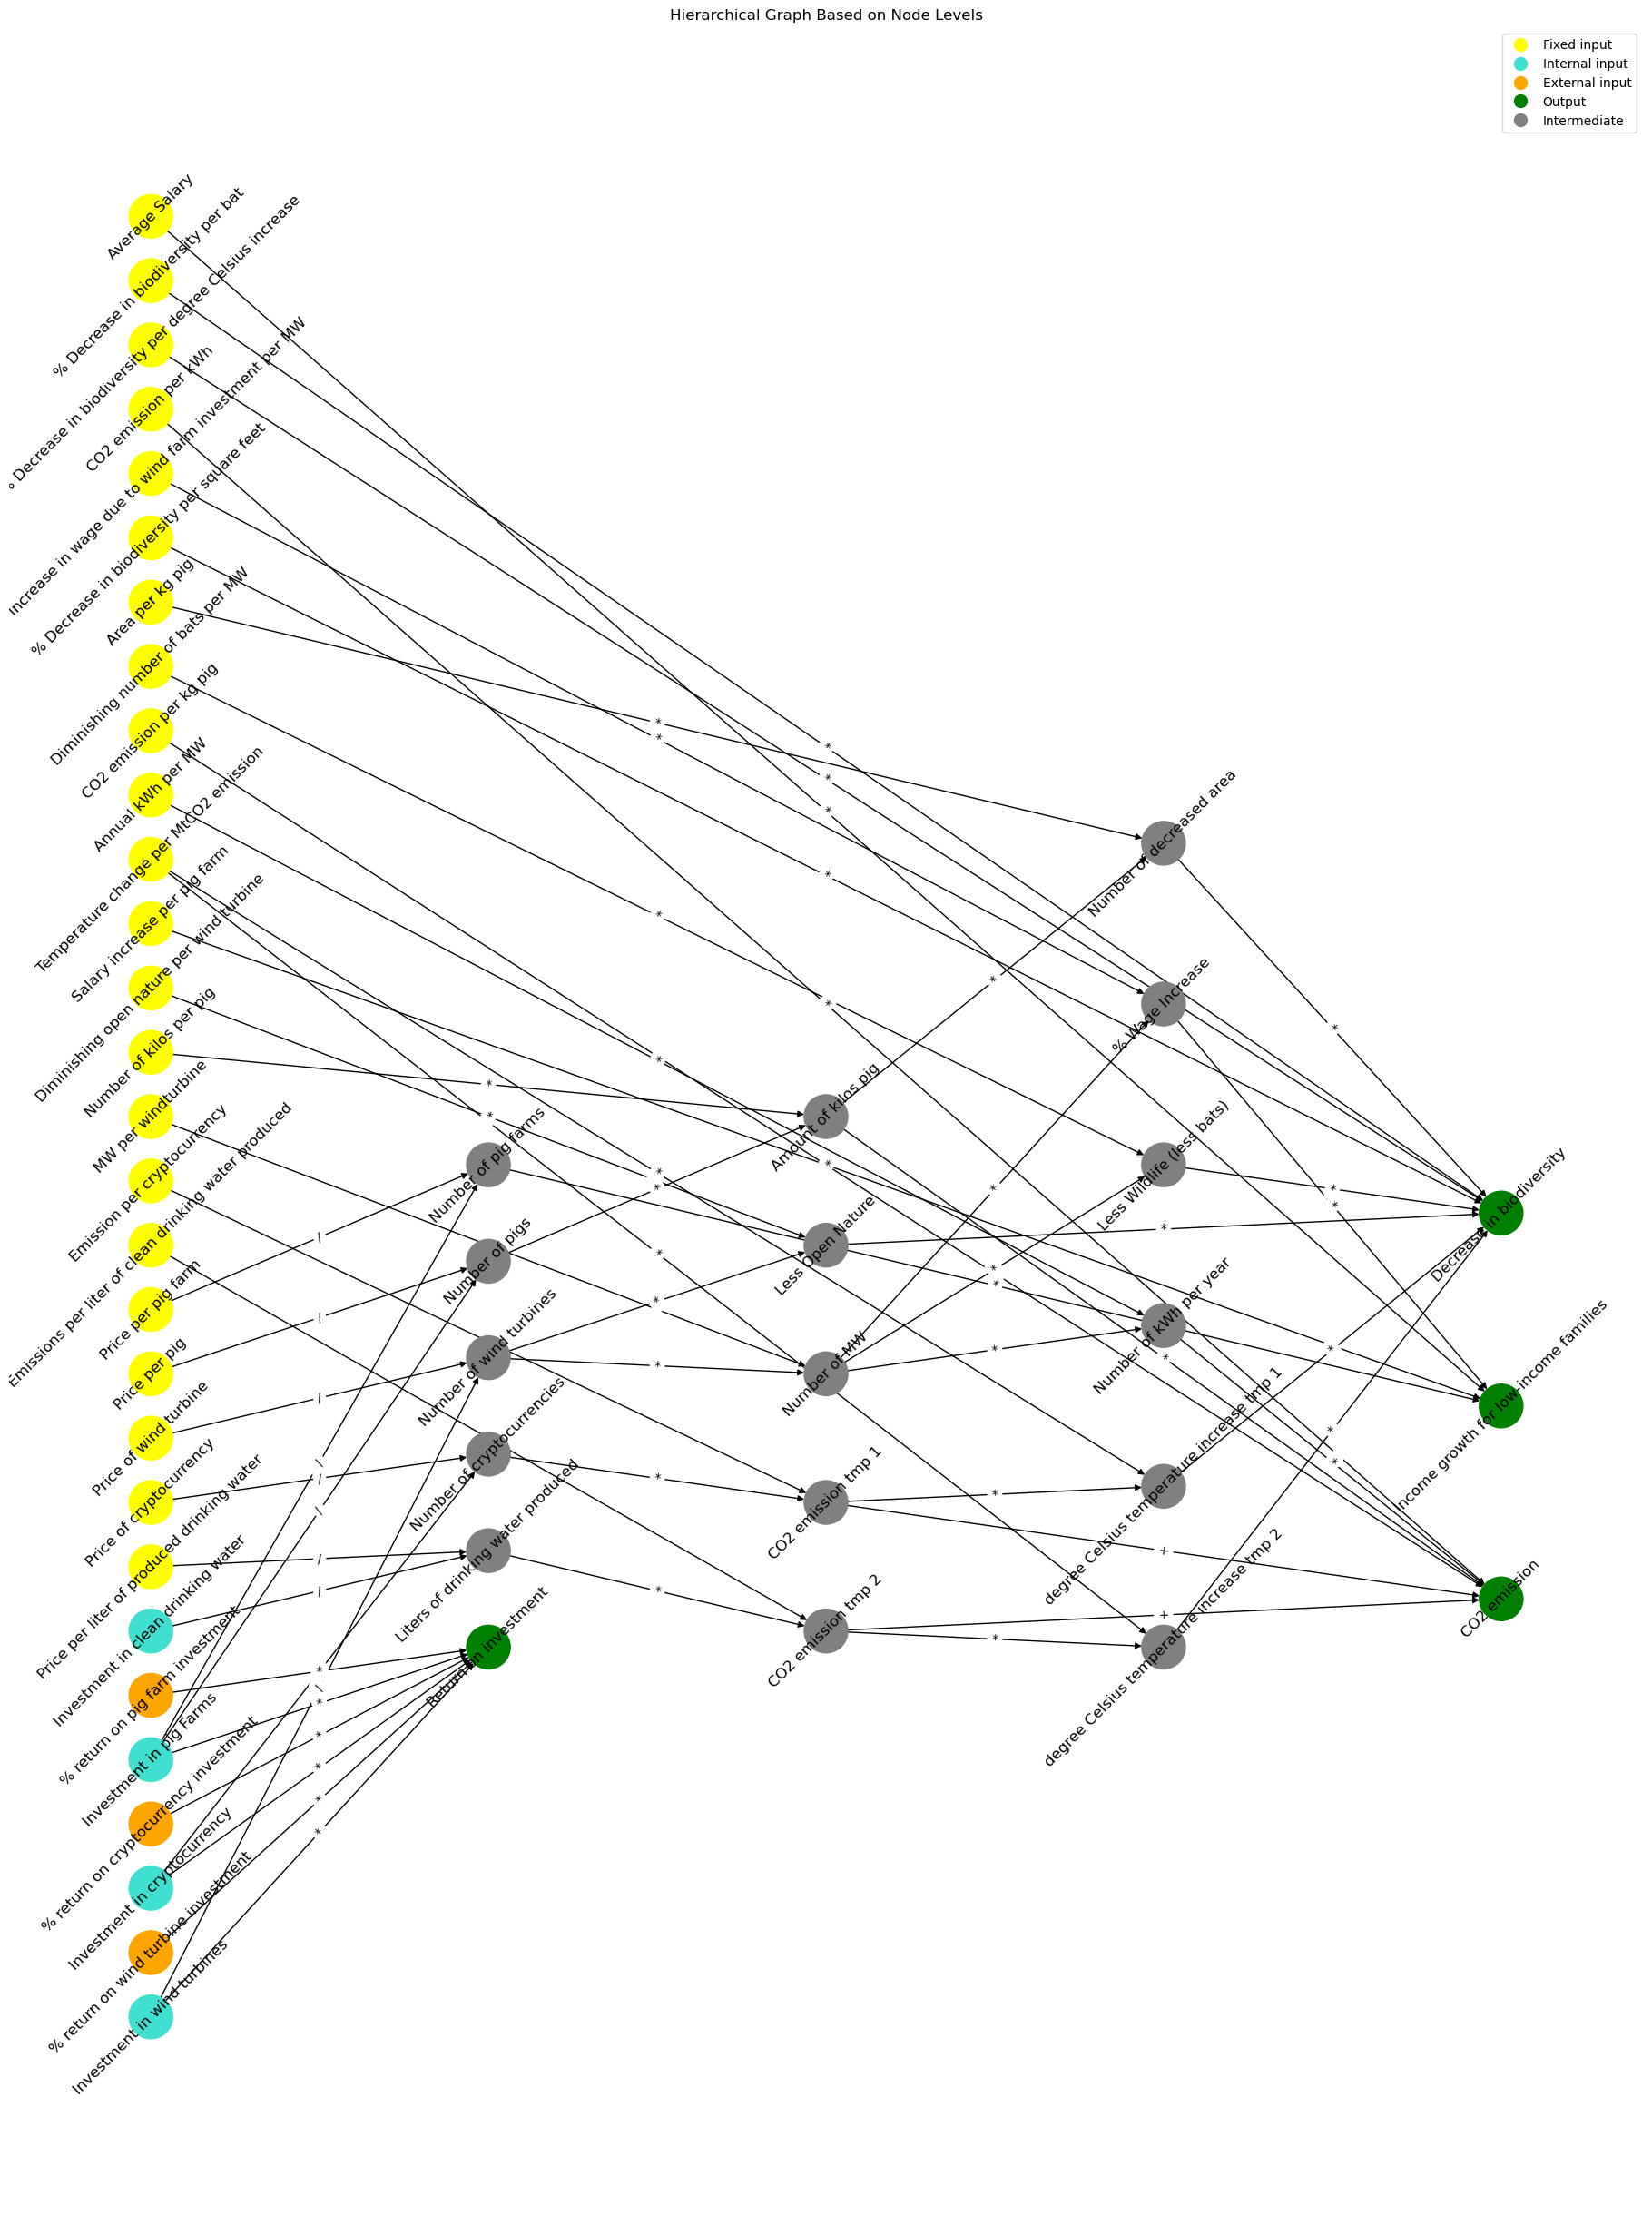

In [173]:
# Create a dictionary to store nodes at each level
nodes_by_level = defaultdict(list)
for i, node_list in enumerate(nx.topological_generations(G)):
    for node in node_list:
        level = i
        nodes_by_level[level].append(node)
    
# Create positions for nodes in the hierarchical layout
pos = {}

# TOP DOWN
# x_spacing = 10  # Adjust this value for spacing between nodes at the same level
# y_spacing = 5.0  # Adjust this value for vertical spacing between levels
# for level, nodes in nodes_by_level.items():
#     num_nodes = len(nodes)
#     x_values = [(i - (num_nodes - 1) / 2) * x_spacing for i in range(num_nodes)]
#     y_value = -level * y_spacing  
#     pos.update((node, (x, y_value)) for node, x in zip(nodes, x_values))

# LEFT TO RIGHT
x_spacing = 1.0  # Adjust this value for spacing between levels
y_spacing = 5.0  # Adjust this value for vertical spacing between nodes at the same level
for level, nodes in nodes_by_level.items():
    num_nodes = len(nodes)
    x_value = level * x_spacing
    y_values = [(i*(level + 2) - (num_nodes - 1) / 2) * y_spacing for i in range(num_nodes)]
    pos.update((node, (x_value, y_value)) for node, y_value in zip(nodes, y_values))

# Plot the graph
edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
node_colors = [G.nodes[node]["color"] for node in G.nodes()]
legend_dict = {
    'Fixed input': 'yellow', 
    'Internal input': 'turquoise', 
    'External input': 'orange', 
    'Output': 'green', 
    'Intermediate': 'grey'
}

plt.figure(figsize=(18, 24))

# with_labels=False because of rotating the node labels
nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=1200, font_size=10)

text = nx.draw_networkx_labels(G, pos)

# Rotate the node labels 
for _, t in text.items():
    t.set_rotation(45) 
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Create and add legend
legend_handles, legend_labels = create_legend(legend_dict)

plt.title("Hierarchical Graph Based on Node Levels")
plt.legend(legend_handles, legend_labels, loc='upper right')
plt.axis('off')  # Turn off axis for cleaner display
plt.show()

In [174]:
number_of_colors = len(data)

COLOR_LIST = ['#000000', '#AD1B02', '#D85604', '#E88D14', '#F3BE26', '#E669A2']
# color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#              for i in range(number_of_colors)]

color = random.choices(COLOR_LIST, k=number_of_colors)
data['dep_color'] = color

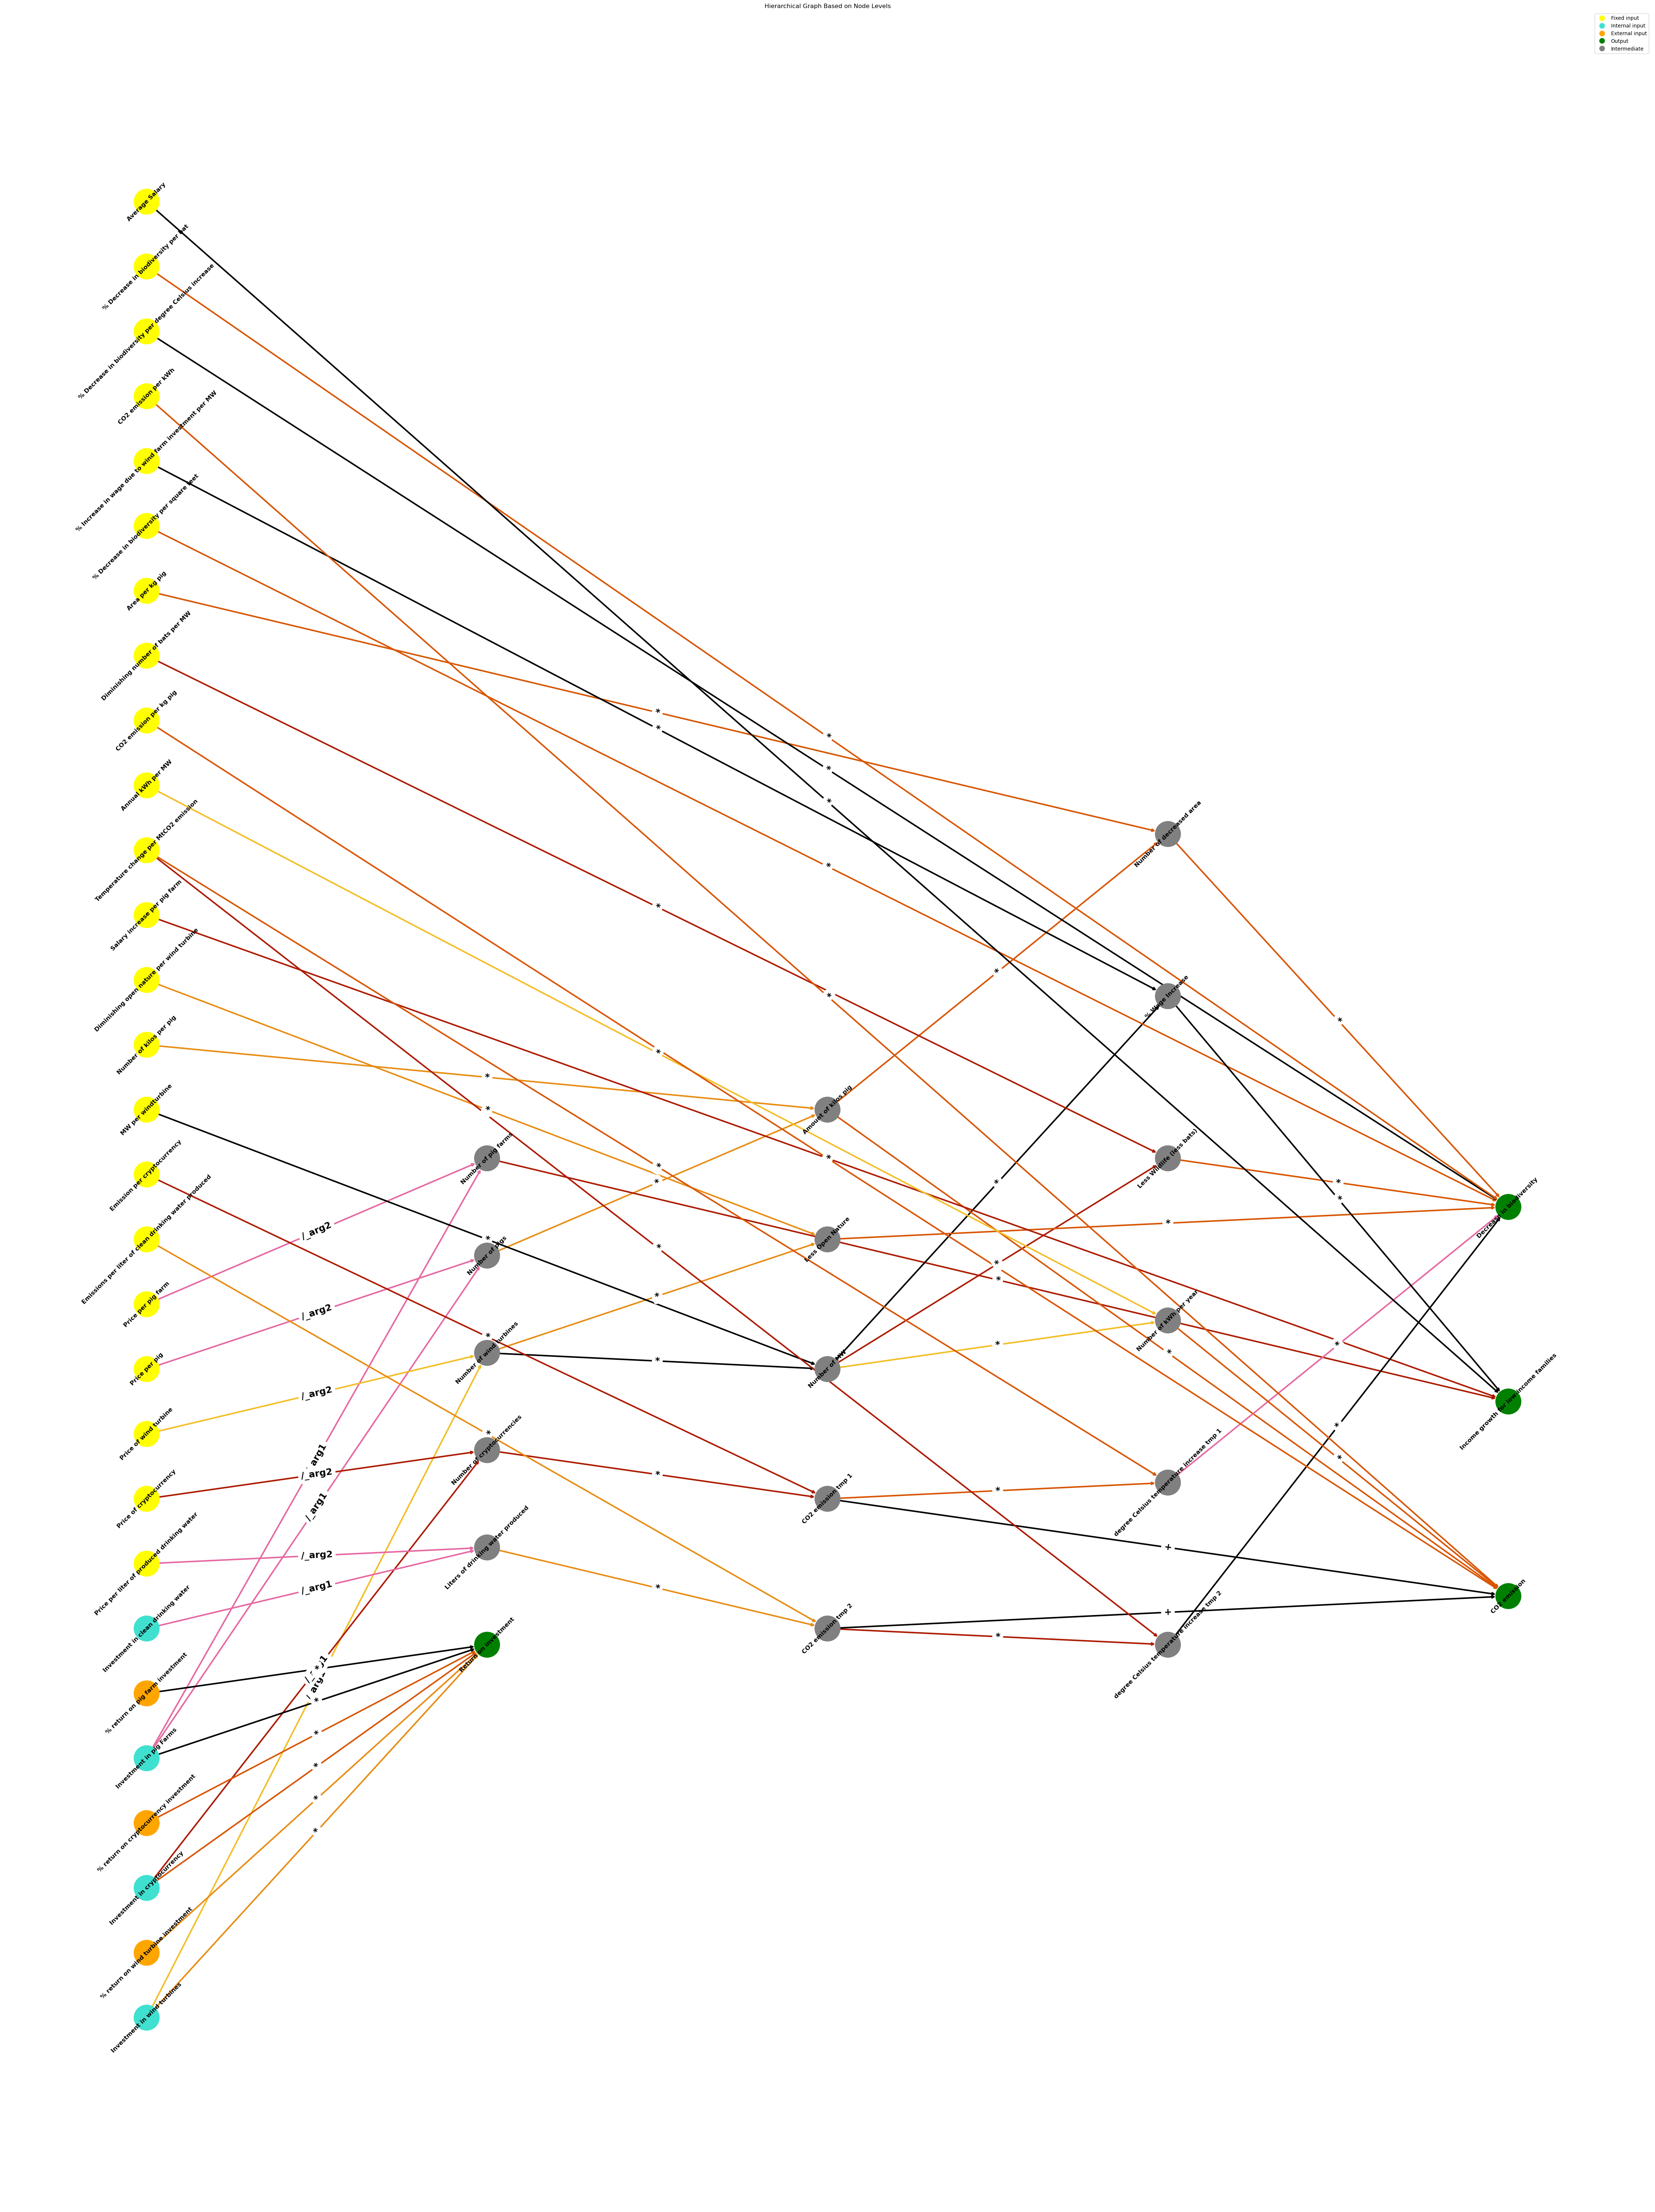

In [175]:
draw_graph(case, data)

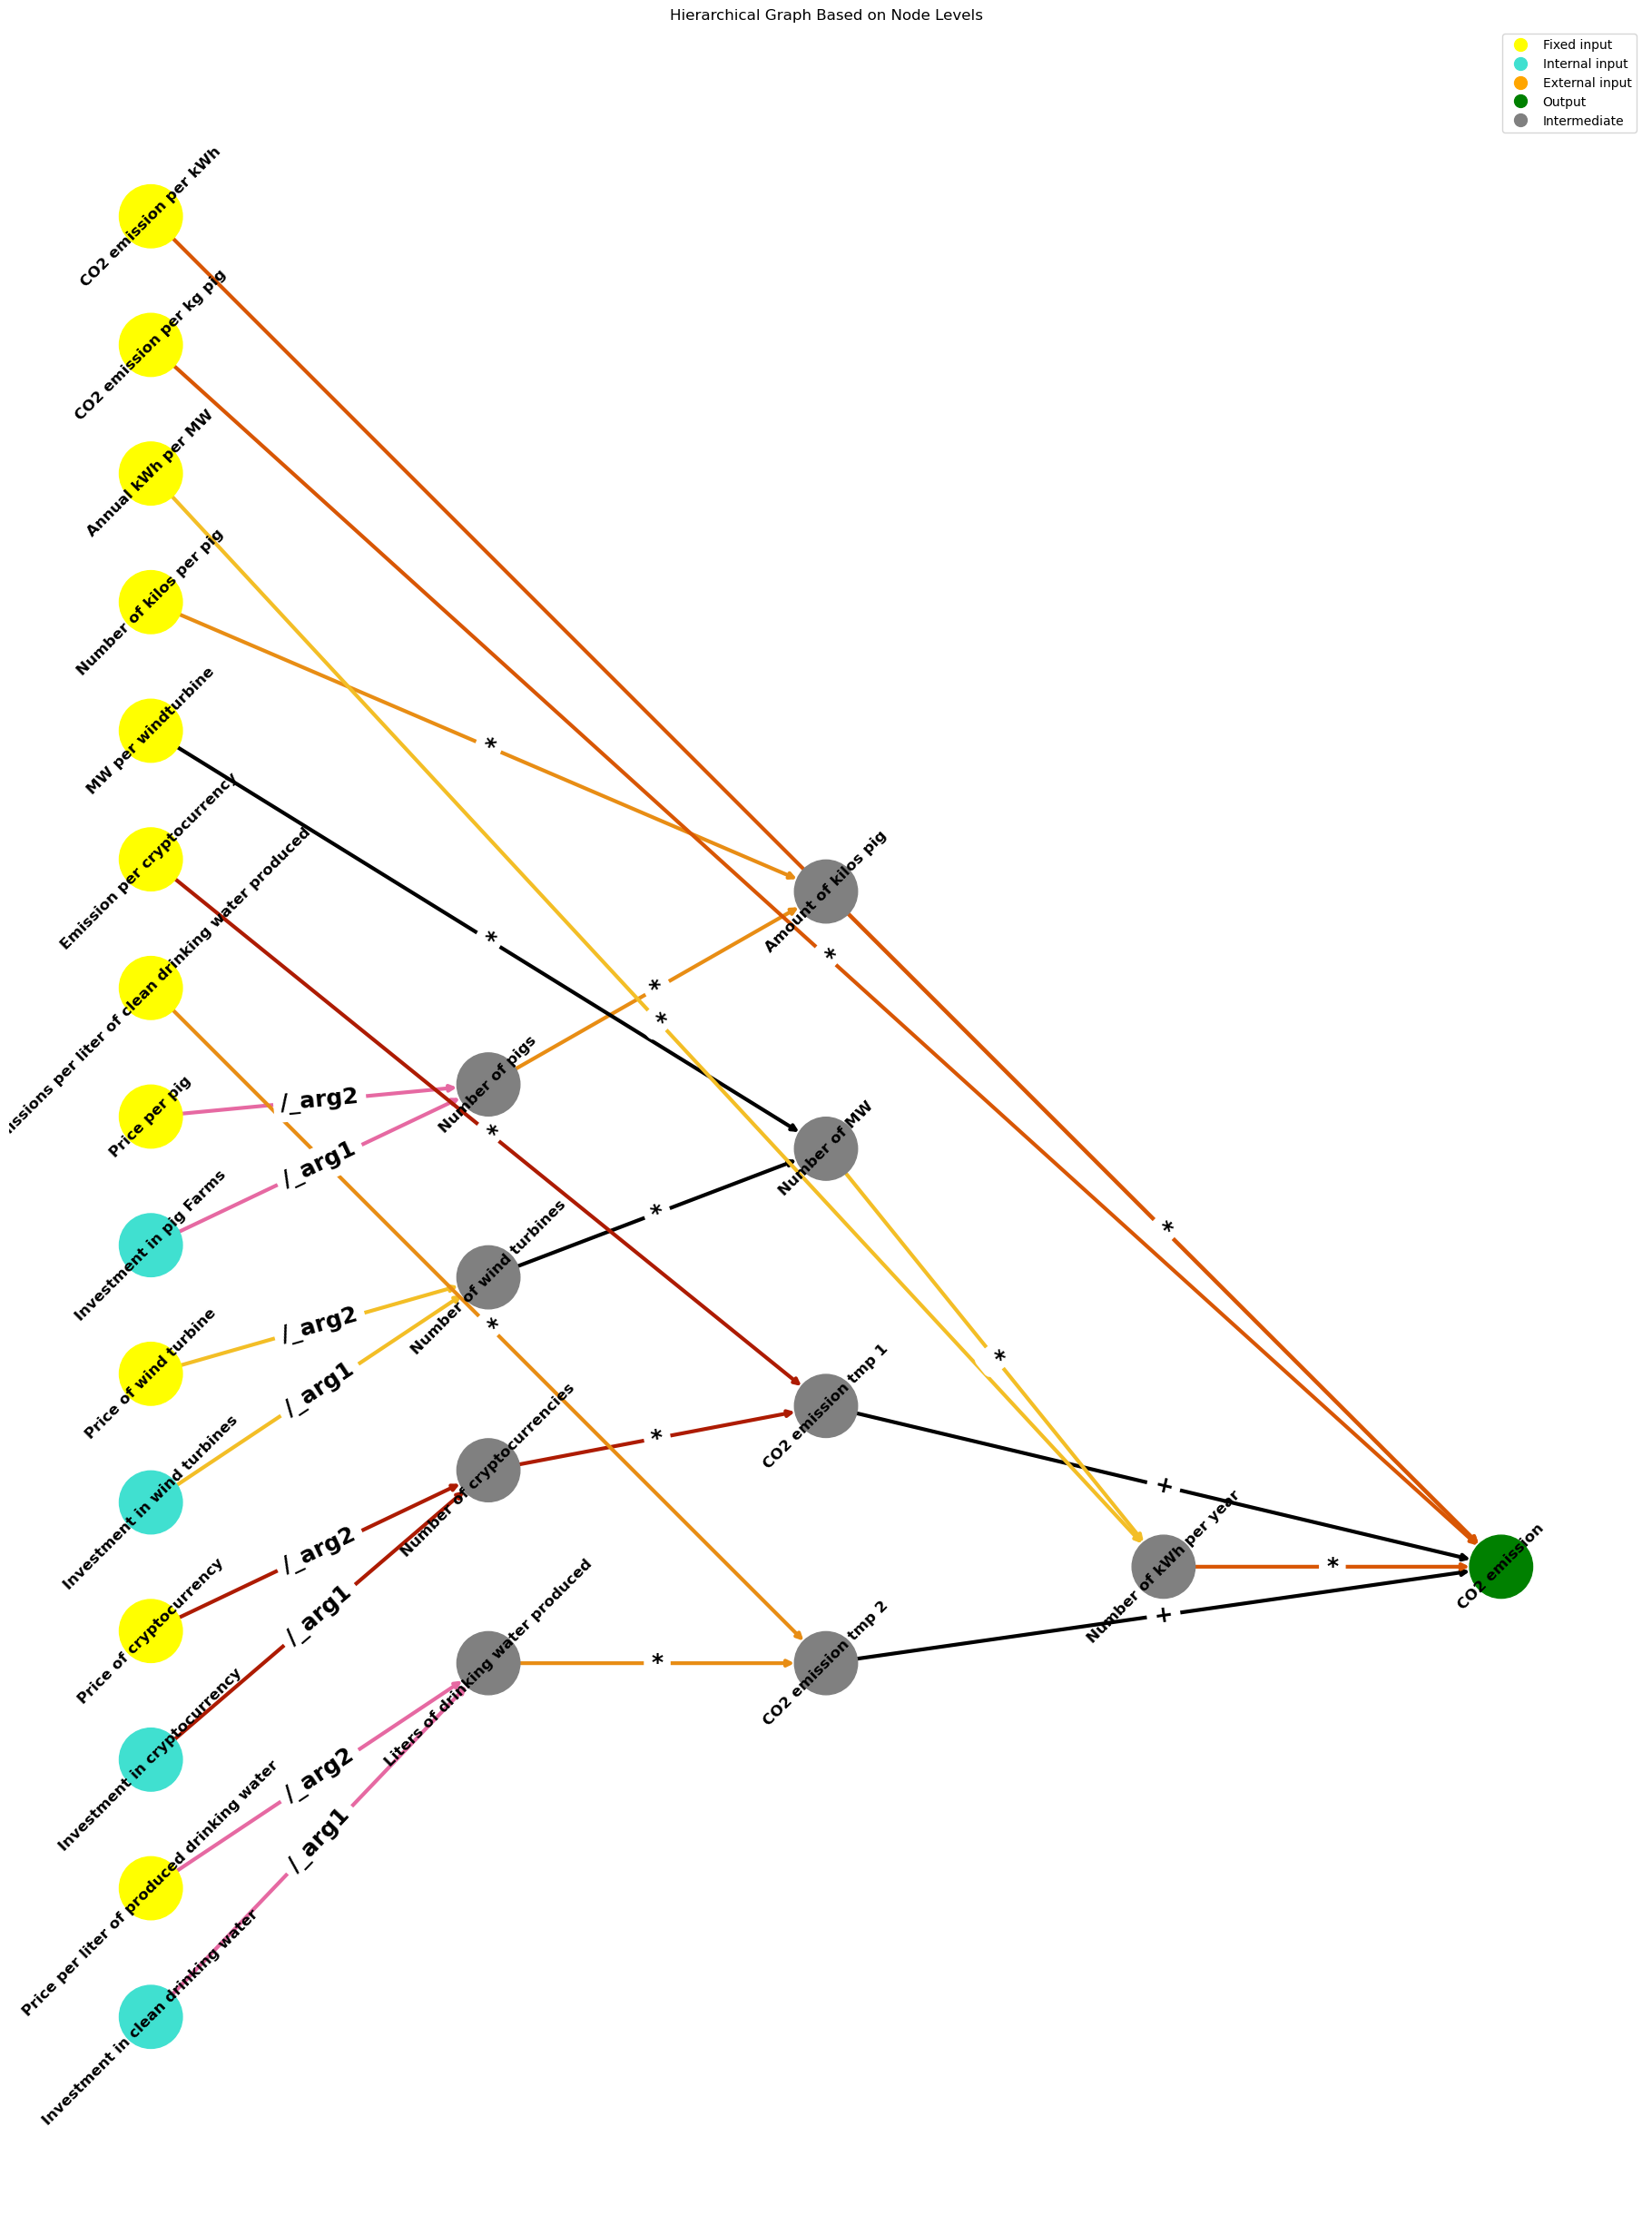

In [176]:
# Test out the subgraph function with a few examples:
select_subset(G, 'CO2 emission')

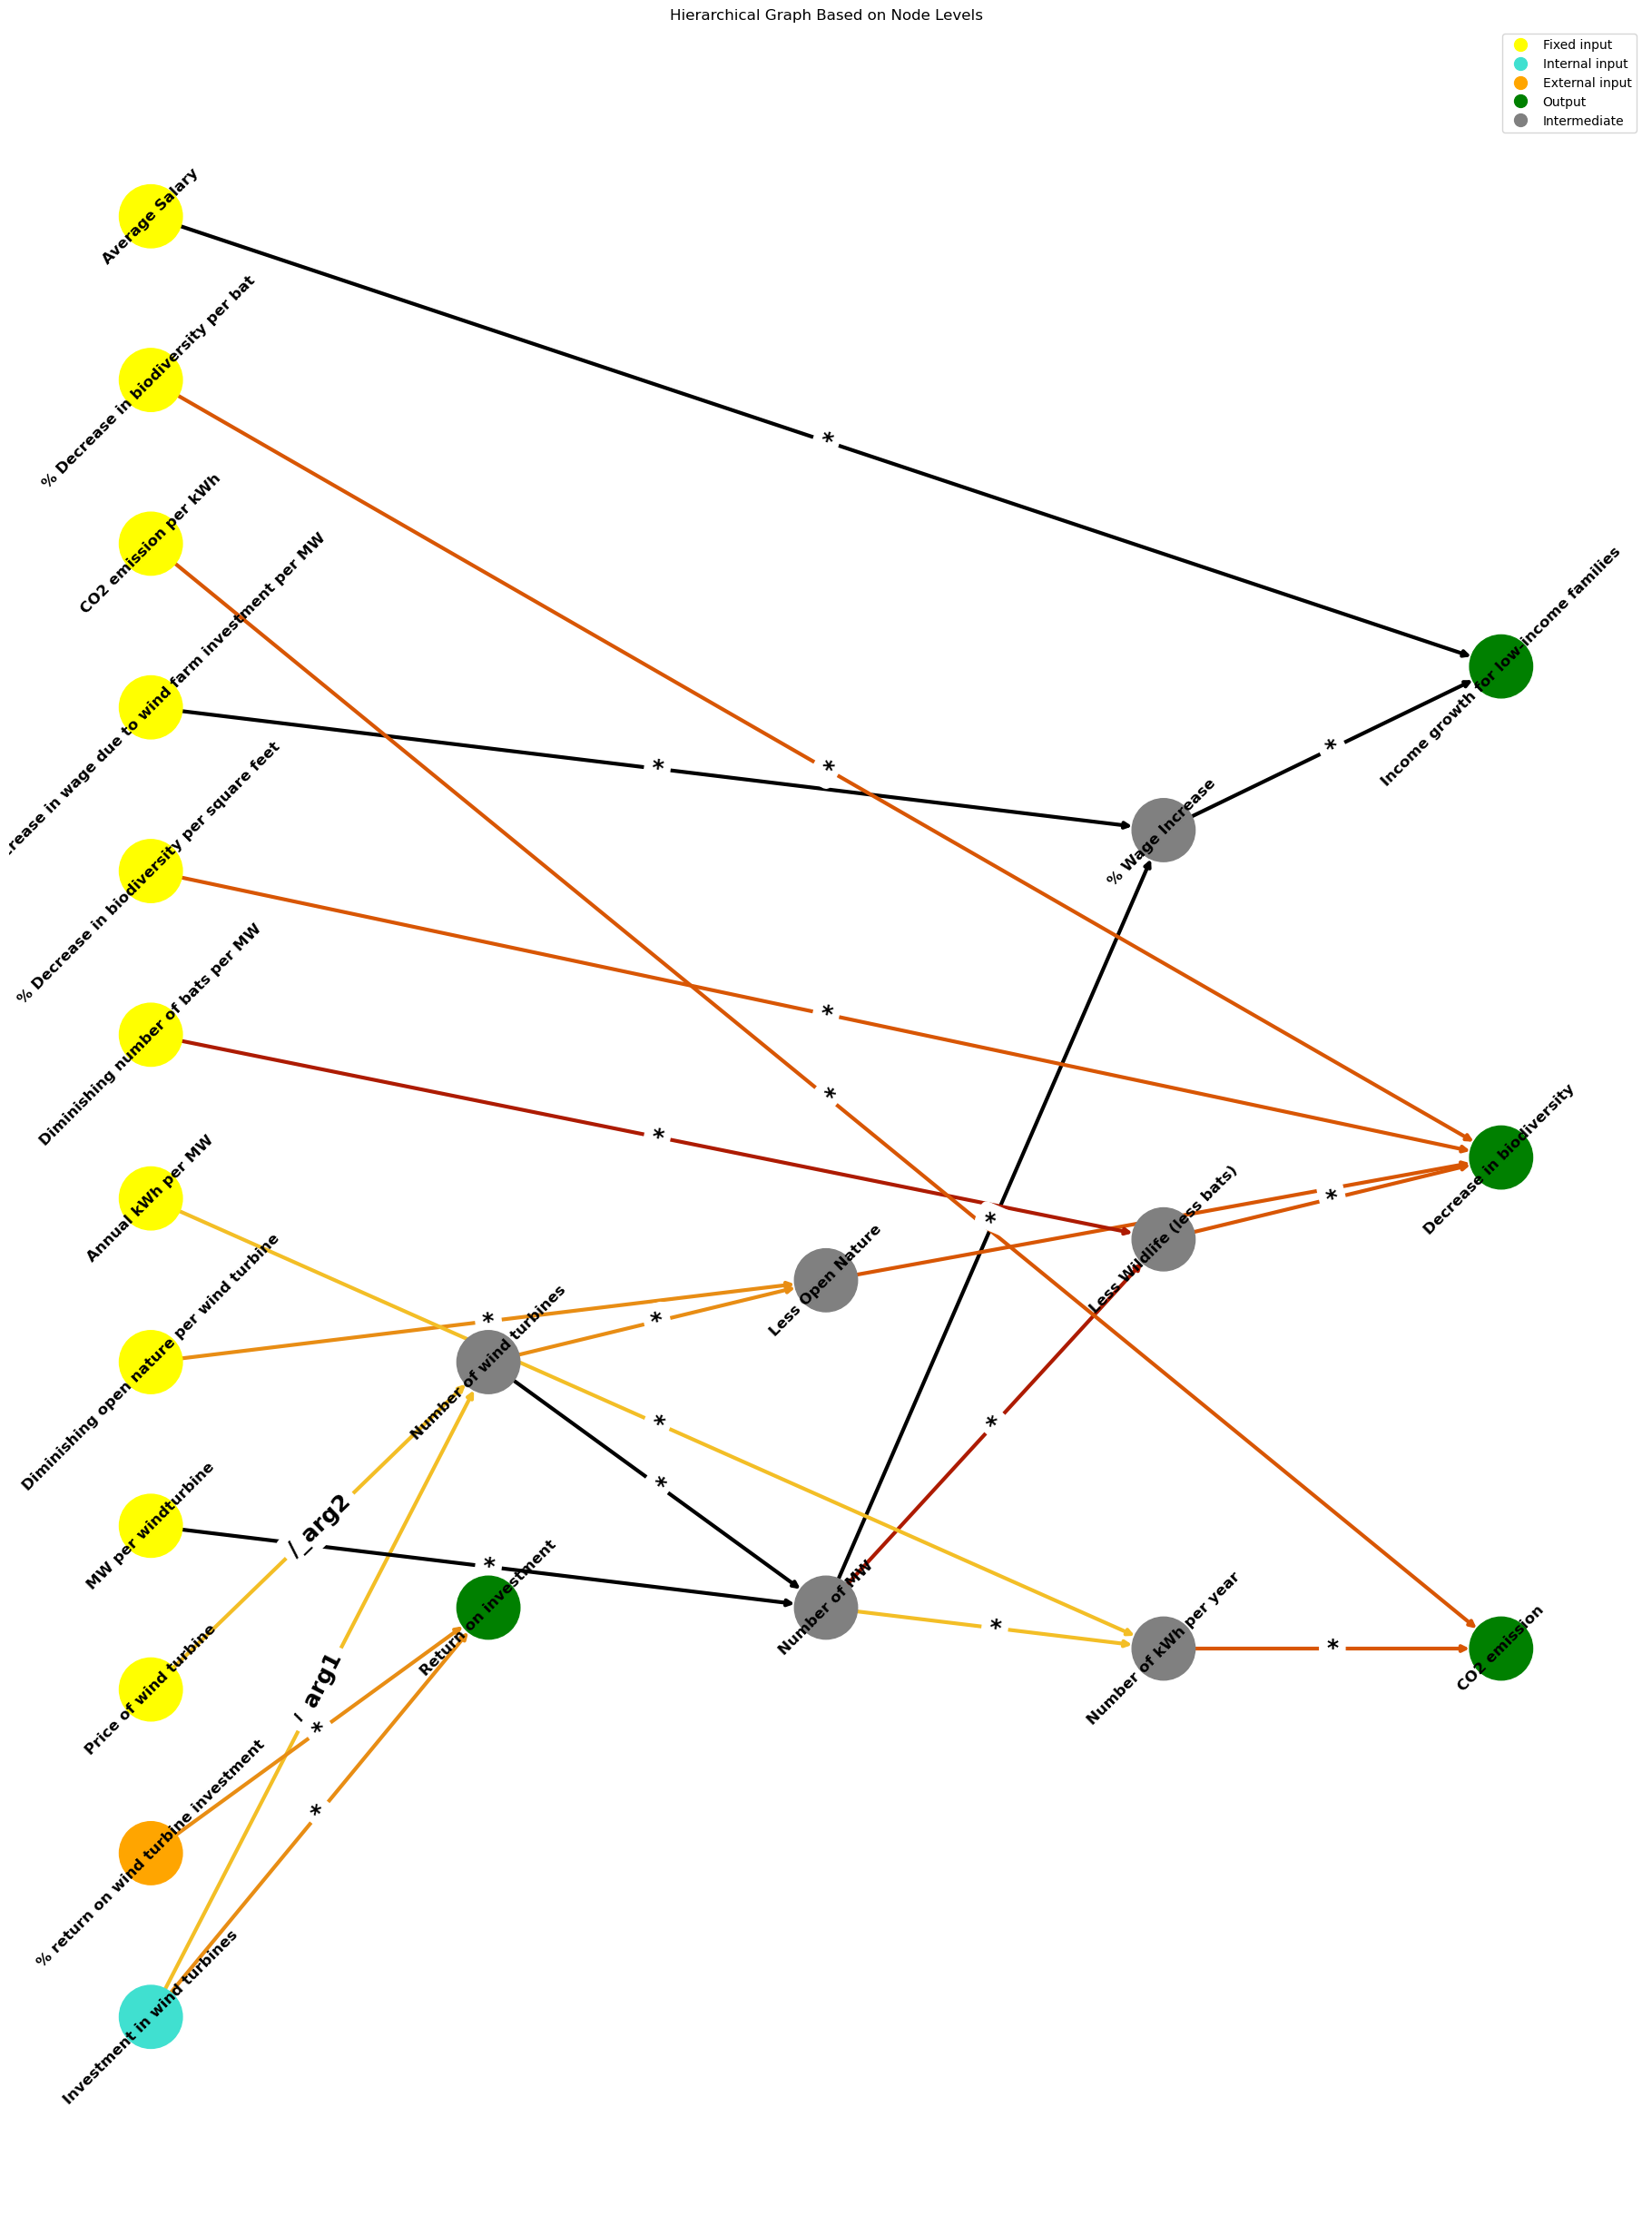

In [177]:
select_subset(G, 'Investment in turbine wind type')

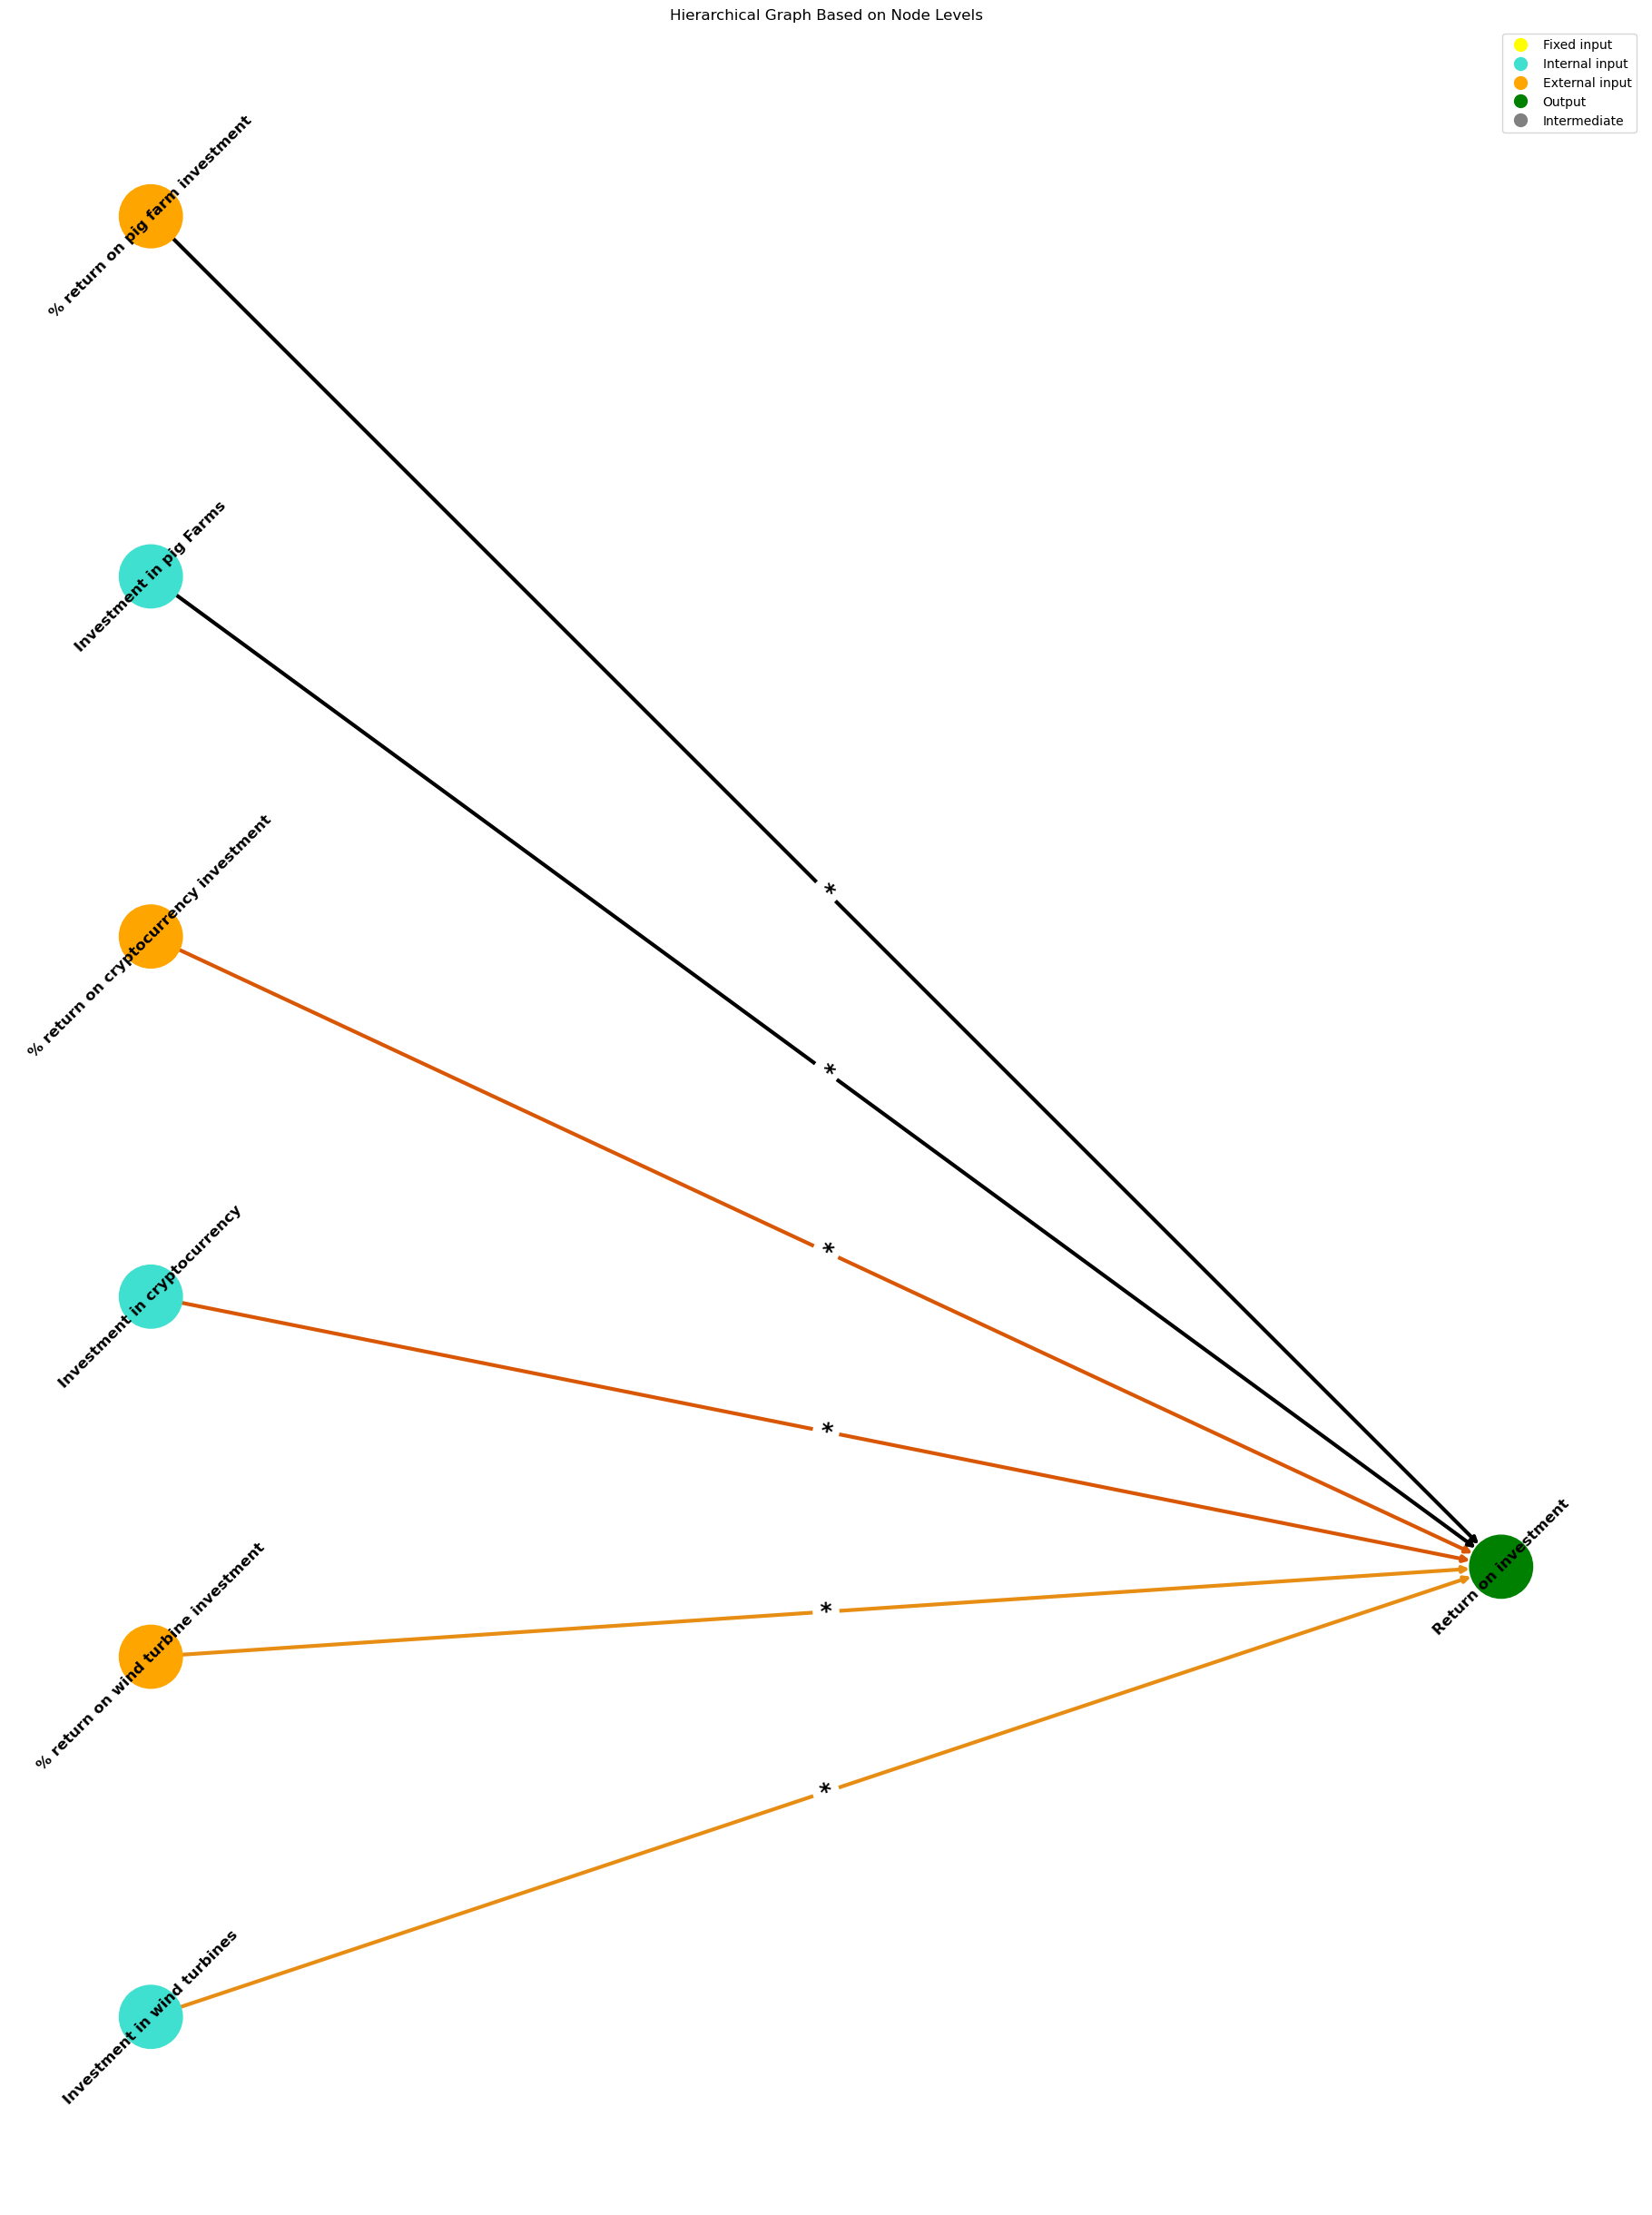

In [178]:
select_subset(G, 'Return on vestmentint')

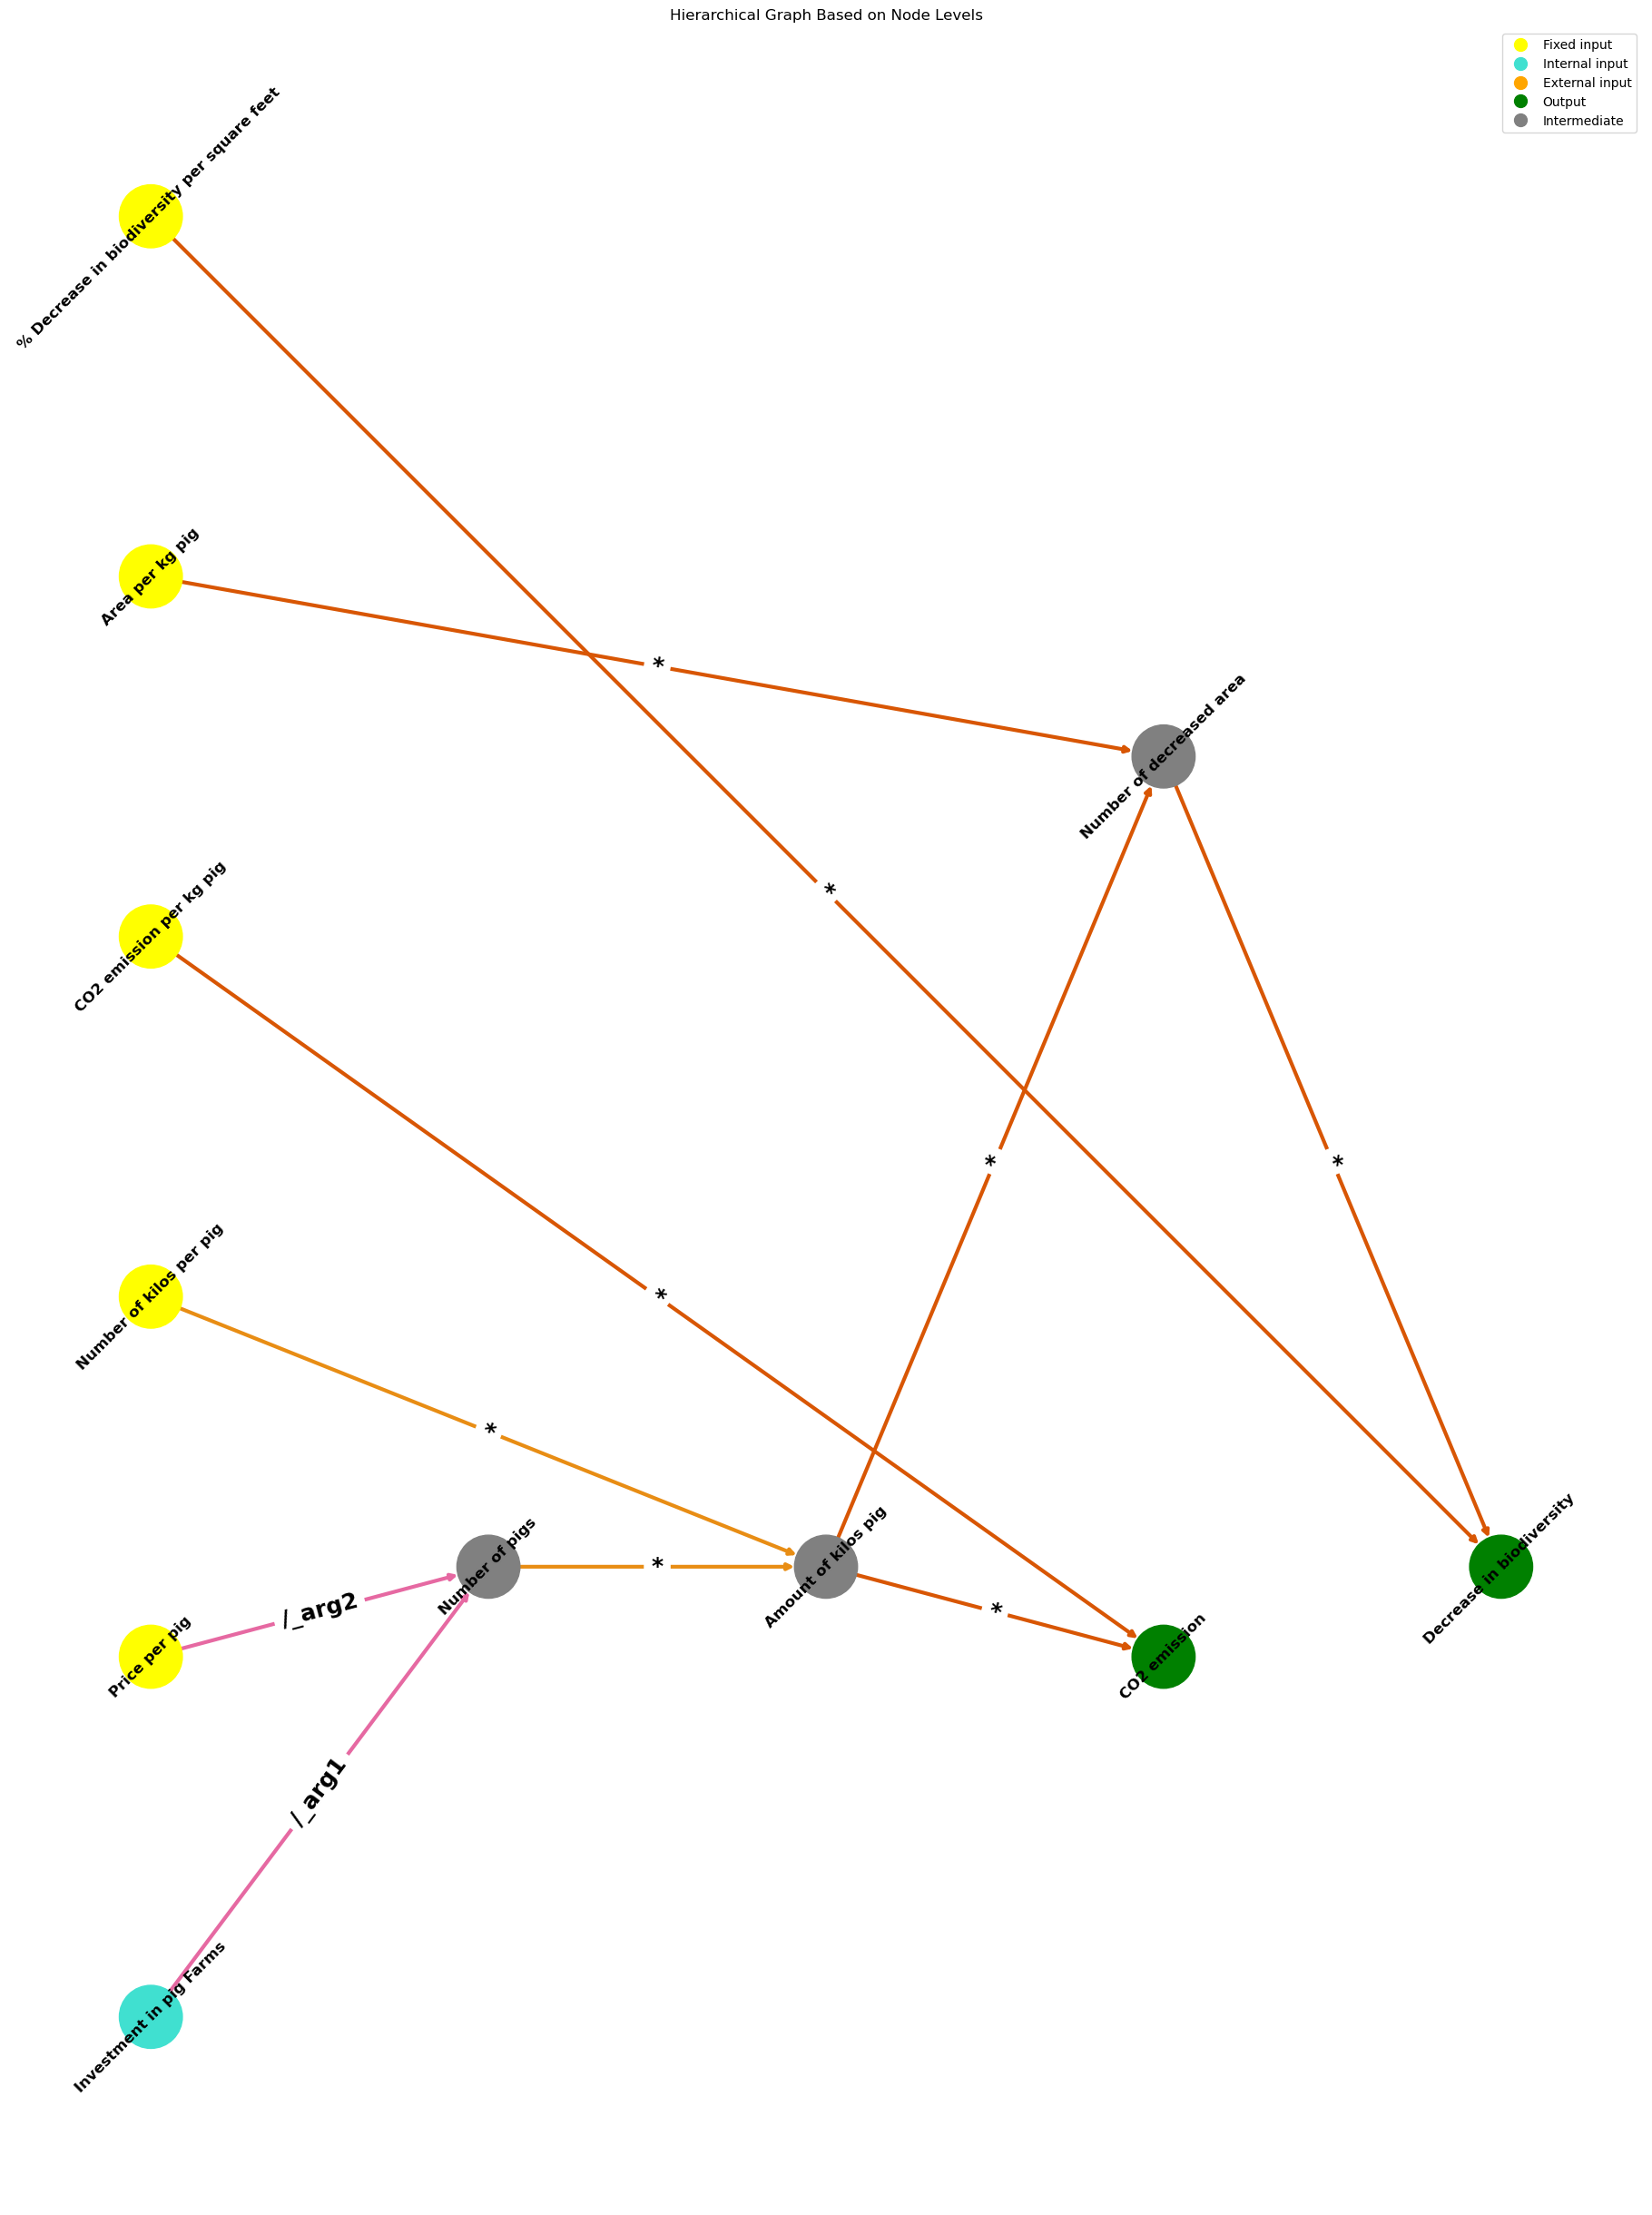

In [179]:
select_subset(G, 'Amount of pig kilos')

### Next Steps

| TO DO                                                              | Status  |
| ------------------------------------------------------------------ | ------- |
| Making the code more robust                                        |         |
| Allowing for slight input mismatch (when specifying node name)     | DONE    |
| Spacing of the graph (E.g.: Sugiyama Layout)                       |         |
| Allowing for a 2 way input (Root node or leaf node)                | DONE    |
| Make the text bolder and thicker edge lines, operator etc.         | DONE    |
| Adding different shapes for nodes in graph                         |         |
| Match legend with correct model object names                       |         |
| Integrating into the Visualize class                               |         |
| Testing with other cases                                           |         |
| PwC Colors for the edge lines                                      | DONE    |

Notes:
- Logic of the subset graph can be better
- Try out other layouts for spacing (e.g. Sugiyama)
- Try the Levenshtein distance algorithm for input mismatch issue

## Visualization frameworks

In [22]:
pip install dagviz

Note: you may need to restart the kernel to use updated packages.


In [23]:
from dagviz import Dagre
Dagre(G)

In [24]:
from dagviz import Metro
Metro(G)